# Imports

In [1]:
import os

import datetime

from typing import Union

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

import catboost
import xgboost

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
import sklearn
from sklearn import set_config

In [3]:
print(f"scikit-learn version is {sklearn.__version__}")

scikit-learn version is 1.4.1.post1


In [4]:
if sklearn.__version__ not in ["1.2.0", "1.2.2", "1.4.1.post1"]:
    os.system("pip install scikit-learn==1.2.0")

# Global Configuration

In [5]:
set_config(transform_output="pandas")

In [6]:
CWD = os.getcwd()
KAGGLE = "kaggle" in CWD

In [7]:
print(CWD)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml


In [9]:
if not KAGGLE:
    PATH_INPUT = os.path.join(CWD, "input")
    PATH_INPUT_TRAIN = os.path.join(PATH_INPUT, "train.csv")
    PATH_INPUT_TEST = os.path.join(PATH_INPUT, "test.csv")
    
    print(os.listdir(PATH_INPUT))
    
else:
    PATH_INPUT_TRAIN = "/kaggle/input/spaceship-titanic/train.csv"
    PATH_INPUT_TEST = "/kaggle/input/spaceship-titanic/test.csv"

['test.csv', 'spaceship-titanic.zip', 'train.csv', 'sample_submission.csv']


In [10]:
sorted(os.listdir(CWD))

['.DS_Store',
 '.ipynb_checkpoints',
 'Benchmark_20240402.ipynb',
 'catboost_info',
 'input',
 'notebooks',
 'outputs',
 'requirements.txt',
 'requirements_py310.txt',
 'venvs',
 'videos']

# Helper functions

In [11]:
def load_data():
    
    X_train = pd.read_csv(PATH_INPUT_TRAIN).set_index("PassengerId")
    X_test = pd.read_csv(PATH_INPUT_TEST).set_index("PassengerId")
    
    return X_train, X_test

# Dataset loading & EDA

In [226]:
X, _ = load_data()

In [244]:
X

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalExpenses
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,8536.0
9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0
9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1873.0


In [236]:
X["TotalExpenses"] = X.iloc[:, 6:11].sum(axis = 1)

In [243]:
(
    X
    .groupby(["HomePlanet"])
    .agg(
        sum_expenses = ("TotalExpenses", np.sum),
        mean_expenses = ("TotalExpenses", np.mean),
        mean_transported = ("Transported", np.mean)
    )
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3828/2080782346.py:2: FutureWarning: The provided callable <function sum at 0x105cfbb50> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3828/2080782346.py:2: FutureWarning: The provided callable <function mean at 0x105d2caf0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


,sum_expenses,mean_expenses,mean_transported
HomePlanet,,,
Earth,3098699.0,673.337462,0.423946
Europa,7355412.0,3451.624589,0.658846
Mars,1849161.0,1051.256964,0.523024


In [237]:
X["TotalExpenses"]

PassengerId
0001_01        0.0
0002_01      736.0
0003_01    10383.0
0003_02     5176.0
0004_01     1091.0
            ...   
9276_01     8536.0
9278_01        0.0
9279_01     1873.0
9280_01     4637.0
9280_02     4826.0
Name: TotalExpenses, Length: 8693, dtype: float64

<Axes: ylabel='Density'>

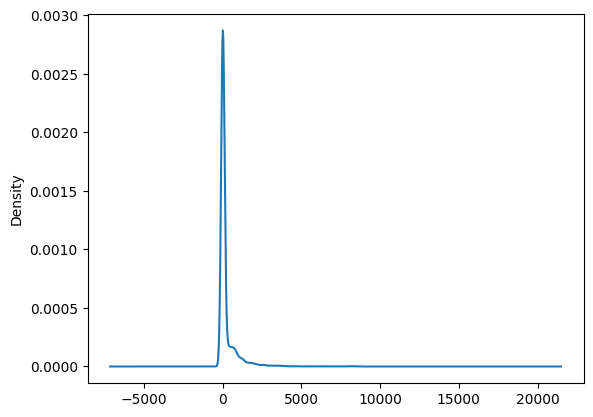

In [230]:
X["RoomService"].plot(kind = "kde")

In [232]:
X["RoomService"].value_counts().sort_index()

RoomService
0.0        5577
1.0         117
2.0          79
3.0          61
4.0          47
           ... 
8209.0        1
8243.0        1
8586.0        1
9920.0        1
14327.0       1
Name: count, Length: 1273, dtype: int64

In [13]:
nulls_per_row = X.isnull()

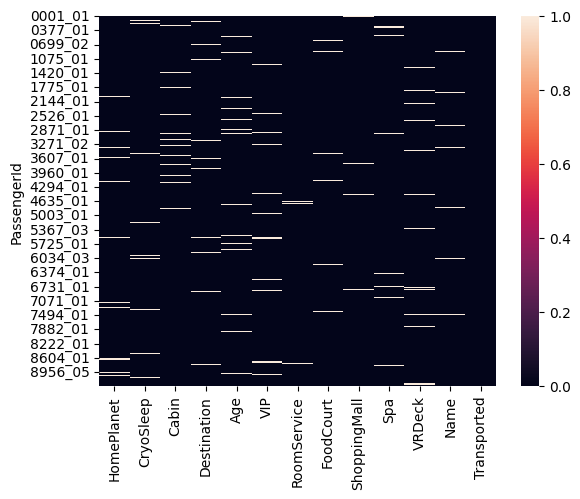

In [14]:
sns.heatmap(nulls_per_row);

In [15]:
def bucketize_age(age):
    
    if 0 <= age < 10:
        return "[0-10)"
    
    elif 10 <= age < 20:
        return "[10-20)"
    
    elif 20 <= age < 30:
        return "[20-30)"
    
    elif 30 <= age < 40:
        return "[30-40)"
    
    elif 40 <= age < 50:
        return "[40-50)"
    
    elif 50 <= age < 60:
        return "[50-60)" 
    
    elif 60 <= age < 70:
        return "[60-70)"
    
    elif age >= 70:
        return "[70 - inf"

In [16]:
Xc = X.copy(deep=True).dropna()

In [17]:
Xc["AgeBuketized"] = Xc["Age"].apply(bucketize_age)

Xc["AgeKBinsDiscretized"] = KBinsDiscretizer(
    encode = "ordinal",
    strategy = "uniform",
    n_bins = 8
).fit_transform(Xc[["Age"]].dropna())

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [18]:
Xc[["AgeKBinsDiscretized", "AgeBuketized"]].drop_duplicates().sort_values("AgeKBinsDiscretized")

,AgeKBinsDiscretized,AgeBuketized
PassengerId,,
0017_01,0.0,[0-10)
0004_01,1.0,[10-20)
0002_01,2.0,[20-30)
0001_01,3.0,[30-40)
0005_01,4.0,[40-50)
0003_01,5.0,[50-60)
0062_01,6.0,[60-70)
0378_03,7.0,[70 - inf


In [19]:
(
    Xc
    .pivot_table(
        index = "AgeBuketized",
        columns = "AgeKBinsDiscretized",
        values = "Age",
        aggfunc = len,
        margins = True,
        fill_value = 0
    )
)

AgeKBinsDiscretized,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
AgeBuketized,,,,,,,,,
[0-10),532,0,0,0,0,0,0,0,532
[10-20),0,1138,0,0,0,0,0,0,1138
[20-30),0,0,2131,0,0,0,0,0,2131
[30-40),0,0,0,1358,0,0,0,0,1358
[40-50),0,0,0,0,812,0,0,0,812
[50-60),0,0,0,0,0,438,0,0,438
[60-70),0,0,0,0,0,0,161,0,161
[70 - inf,0,0,0,0,0,0,0,36,36
All,532,1138,2131,1358,812,438,161,36,6606


In [20]:
Xc[["AgeKBinsDiscretized", "AgeBuketized", "Age"]].drop_duplicates().sort_values("Age")

,AgeKBinsDiscretized,AgeBuketized,Age
PassengerId,,,
0017_01,0.0,[0-10),0.0
0020_01,0.0,[0-10),1.0
0031_02,0.0,[0-10),2.0
0092_03,0.0,[0-10),3.0
0044_02,0.0,[0-10),4.0
...,...,...,...
1222_01,7.0,[70 - inf,75.0
1455_05,7.0,[70 - inf,76.0
3176_01,7.0,[70 - inf,77.0


In [21]:
r_ = (
    Xc
    .groupby("AgeBuketized")
    .agg(
        nr = ("CryoSleep", len),
        mean_transported = ("Transported", np.mean)
    )
    .reset_index()
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3828/125699061.py:2: FutureWarning: The provided callable <function mean at 0x105d2caf0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  Xc


In [22]:
r_

,AgeBuketized,nr,mean_transported
0,[0-10),532,0.721805
1,[10-20),1138,0.534271
2,[20-30),2131,0.474894
3,[30-40),1358,0.443299
4,[40-50),812,0.502463
5,[50-60),438,0.495434
6,[60-70),161,0.503106
7,[70 - inf,36,0.416667


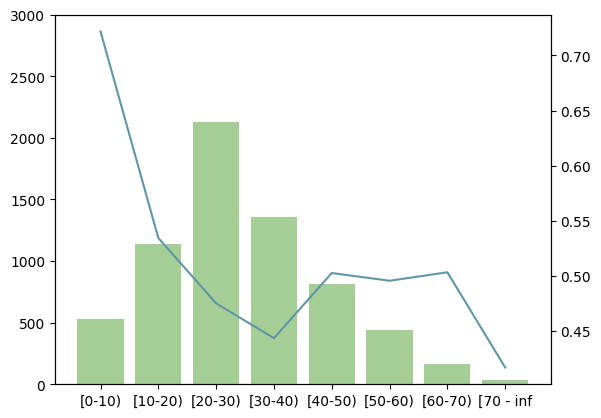

In [24]:
fig = plt.figure()
ax = fig.subplots()

ax.bar(x = r_["AgeBuketized"], height = r_["nr"], color = "#A4CE95")

ax.set_ylim(bottom=0, top=3000)

ax2 = ax.twinx()

ax2.plot(r_["mean_transported"], color = "#6196A6");

In [25]:
(X.isnull().sum(axis = 1) == X.shape[1]).sum()

0

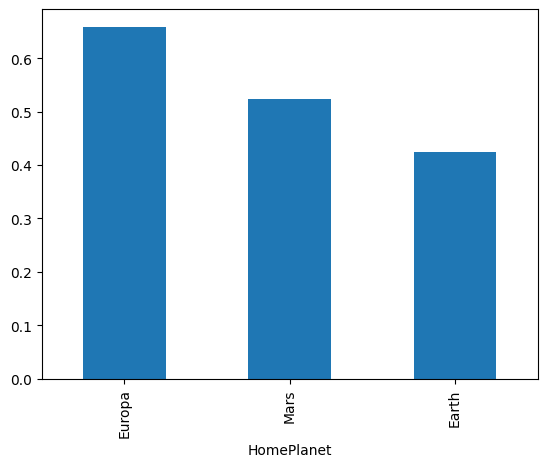

In [26]:
(
    X
    .groupby("HomePlanet")
    ["Transported"]
    .mean()
    .sort_values(ascending = False)
    .plot(kind = "bar")
);

In [27]:
X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [28]:
_ = (
    X
    .groupby(["HomePlanet", "CryoSleep"])
    .agg(
        nr_rows = ("Cabin", len),
        transported_ratio = ("Transported", np.mean)
    )
    .assign(
        nr_rows_pct = lambda df: round((df["nr_rows"]/df["nr_rows"].sum())*100, 2),
        transported_ratio = lambda df: round(df["transported_ratio"] * 100, 2)
    )
);

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3828/3554285840.py:2: FutureWarning: The provided callable <function mean at 0x105d2caf0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


In [29]:
_

nr_rows  transported_ratio  nr_rows_pct
HomePlanet CryoSleep                                         
Earth      False         3106              32.10        37.53
           True          1382              65.63        16.70
Europa     False         1162              40.02        14.04
           True           911              98.90        11.01
Mars       False         1047              27.70        12.65
           True           669              91.18         8.08

In [30]:
X["LenCabin"] = X["Cabin"].apply(lambda cabin: len(str(cabin)))

In [31]:
X.groupby(["LenCabin"]).size()

LenCabin
3     199
5     130
6    1201
7    5043
8    2120
dtype: int64

In [32]:
X[X["LenCabin"] == 5].head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,LenCabin
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,5
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,5
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,5
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,5


In [33]:
X["Cabin"].fillna("NA", inplace = True)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3828/3468940878.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Cabin"].fillna("NA", inplace = True)


In [34]:
X["CabinFirstLetter"] = X["Cabin"].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin)
X["CabinLastLetter"] = X["Cabin"].apply(lambda cabin: cabin[-1] if cabin != "NA" else cabin)

In [35]:
X["CabinFirstLetter"].value_counts().sort_index()

CabinFirstLetter
A      256
B      779
C      747
D      478
E      876
F     2794
G     2559
NA     199
T        5
Name: count, dtype: int64

In [36]:
X["CabinLastLetter"].value_counts().sort_index()

CabinLastLetter
NA     199
P     4206
S     4288
Name: count, dtype: int64

In [37]:
X["Cabin"].sample(10)

PassengerId
5814_02     D/176/S
1033_01     G/154/P
7711_01     D/241/P
8307_01     A/100/S
2853_01     F/544/S
0726_01     G/111/P
4373_01     F/822/S
1882_02          NA
6991_02     B/233/P
6172_01    G/1001/S
Name: Cabin, dtype: object

In [38]:
(
    X
    .groupby(["CabinFirstLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

CabinFirstLetter
A     0.496094
B     0.734275
C     0.680054
D     0.433054
E     0.357306
F     0.439871
G     0.516217
NA    0.502513
T     0.200000
Name: Transported, dtype: float64

In [39]:
(
    X
    .groupby(["CabinLastLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

CabinLastLetter
NA    0.502513
P     0.451260
S     0.555037
Name: Transported, dtype: float64

In [40]:
pd.concat([
    (
        X
        .groupby(["CabinFirstLetter", "CabinLastLetter"])
        ["Transported"]
        .mean()
        .sort_index()
        .unstack()
    ),
    (
        X
        .groupby(["CabinFirstLetter"])
        ["Transported"]
        .mean()
        .sort_index()
    )], axis = 1)

,NA,P,S,Transported
CabinFirstLetter,,,,
A,NaN,0.435897,0.546763,0.496094
B,NaN,0.674221,0.784038,0.734275
C,NaN,0.580645,0.763547,0.680054
D,NaN,0.403226,0.465217,0.433054
E,NaN,0.342657,0.371365,0.357306
F,NaN,0.410987,0.470501,0.439871
G,NaN,0.448276,0.583788,0.516217
NA,0.502513,NaN,NaN,0.502513
T,NaN,0.250000,0.000000,0.200000


In [41]:
X.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,LenCabin
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,6.984240
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.898869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,7.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


In [42]:
X.isnull().sum()

HomePlanet          201
CryoSleep           217
Cabin                 0
Destination         182
Age                 179
VIP                 203
RoomService         181
FoodCourt           183
ShoppingMall        208
Spa                 183
VRDeck              188
Name                200
Transported           0
LenCabin              0
CabinFirstLetter      0
CabinLastLetter       0
dtype: int64

In [43]:
X.shape

(8693, 16)

In [44]:
(
    X
    .pivot_table(
        index = "HomePlanet",
        columns = "Destination",
        values = "Transported",
        aggfunc = [len, np.mean],
        margins = True
    )
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3828/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x105d2caf0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3828/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x105d2caf0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_3828/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x105d2caf0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


len                                        mean  \
Destination 55 Cancri e PSO J318.5-22 TRAPPIST-1e   All 55 Cancri e   
HomePlanet                                                            
Earth               690           712        3101  4503    0.504348   
Europa              886            19        1189  2094    0.689616   
Mars                193            49        1475  1717    0.611399   
All                1769           780        5765  8314    0.608819   

                                                 
Destination PSO J318.5-22 TRAPPIST-1e       All  
HomePlanet                                       
Earth            0.498596    0.389229  0.424162  
Europa           0.736842    0.634987  0.659026  
Mars             0.448980    0.511864  0.521258  
All              0.501282    0.471292  0.503368

In [45]:
X["Name"].fillna("NA").apply(lambda name: len(name.split(" "))).value_counts()

Name
2    8493
1     200
Name: count, dtype: int64

In [46]:
X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,LenCabin,CabinFirstLetter,CabinLastLetter
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,5,B,P
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,5,F,S
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,5,A,S
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5,A,S
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,5,F,S


In [47]:
X["Surname"] = X["Name"].fillna("NA").apply(lambda name: name.split(" ")[1] if name != "NA" else name)

In [48]:
X["Surname"]

PassengerId
0001_01      Ofracculy
0002_01          Vines
0003_01         Susent
0003_02         Susent
0004_01    Santantines
              ...     
9276_01      Noxnuther
9278_01      Mondalley
9279_01         Connon
9280_01      Hontichre
9280_02      Hontichre
Name: Surname, Length: 8693, dtype: object

In [49]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
)

Surname
Acobson        0.250000
Acobsond       0.333333
Adavisons      0.444444
Adkinson       0.000000
Admingried     0.750000
                 ...   
Wynneyerson    0.500000
Yanton         0.285714
Yatters        0.500000
Yorkland       0.636364
Youngrayes     0.333333
Name: Transported, Length: 2218, dtype: float64

In [50]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
    .value_counts(normalize=True)
    .sort_index()
)

Transported
0.000000    0.165915
0.111111    0.000902
0.125000    0.002254
0.142857    0.002705
0.166667    0.009468
0.200000    0.019387
0.222222    0.000451
0.230769    0.000451
0.250000    0.037421
0.266667    0.000451
0.272727    0.001353
0.285714    0.010821
0.300000    0.001353
0.307692    0.000451
0.333333    0.076646
0.357143    0.000451
0.363636    0.001353
0.375000    0.009017
0.384615    0.000451
0.388889    0.000451
0.400000    0.033814
0.416667    0.000451
0.428571    0.015329
0.444444    0.003607
0.454545    0.003156
0.461538    0.000451
0.500000    0.168170
0.505000    0.000451
0.545455    0.001353
0.555556    0.004959
0.571429    0.012624
0.583333    0.001353
0.600000    0.034265
0.615385    0.000451
0.625000    0.004058
0.636364    0.003156
0.642857    0.000451
0.666667    0.080703
0.700000    0.000902
0.714286    0.009017
0.727273    0.000902
0.750000    0.040126
0.769231    0.000451
0.777778    0.001353
0.800000    0.021641
0.833333    0.009017
0.857143    0.002705
0

In [51]:
del X, _

# Preprocessing and Modelling

In [53]:
X_train, X_test = load_data()

In [54]:
y = X_train.pop("Transported")

In [55]:
class DebuggerTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print("DummyTransformer")
        return X

In [56]:
class CabinLetterExtractor(BaseEstimator, TransformerMixin):
    
    
    def __init__(self, letter:Union["first", "last"], verbose:bool=False):
        
        self.__assert_letter(letter=letter)
        
        self.letter = letter
        self.verbose = verbose
        
    def __assert_letter(self, letter):
        
        assert_message = "Valid letters are `first` or `last`."
        assert_message += f"You have passed {letter}"
        
        assert letter in ["first", "last"], assert_message
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        if self.verbose:
            print("CabinLetterExtractor")
            print(type(X))
            
        if self.letter == "first":
            return X.iloc[:, 0].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin).to_frame()
        else:
            return X.iloc[:, 0].apply(lambda cabin: cabin[-1] if cabin != "NA" else cabin).to_frame()

In [57]:
ct_impute = ColumnTransformer(
    transformers = [
        ("impute_numerical", SimpleImputer(strategy="mean"), make_column_selector(dtype_include=np.number)),
        ("impute_cabin", SimpleImputer(strategy="constant", fill_value="NA"), ["Cabin"]),
        (
            "impute_categorical",
            SimpleImputer(strategy="most_frequent"),
            ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name']
        )
    ],
    remainder = 'drop'
)

In [58]:
ct_impute

ColumnTransformer(transformers=[('impute_numerical', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17de38fa0>),
                                ('impute_cabin',
                                 SimpleImputer(fill_value='NA',
                                               strategy='constant'),
                                 ['Cabin']),
                                ('impute_categorical',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'Name'])])

In [59]:
Xt = ct_impute.fit_transform(X_train)

In [60]:
Xt.shape

(8693, 12)

In [61]:
Xt.head()

,impute_numerical__Age,impute_numerical__RoomService,impute_numerical__FoodCourt,impute_numerical__ShoppingMall,impute_numerical__Spa,impute_numerical__VRDeck,impute_cabin__Cabin,impute_categorical__HomePlanet,impute_categorical__CryoSleep,impute_categorical__Destination,impute_categorical__VIP,impute_categorical__Name
PassengerId,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,B/0/P,Europa,False,TRAPPIST-1e,False,Maham Ofracculy
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,F/0/S,Earth,False,TRAPPIST-1e,False,Juanna Vines
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,A/0/S,Europa,False,TRAPPIST-1e,True,Altark Susent
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,A/0/S,Europa,False,TRAPPIST-1e,False,Solam Susent
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,F/1/S,Earth,False,TRAPPIST-1e,False,Willy Santantines


In [62]:
class SurnameExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, verbose:bool=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.iloc[:, 0].apply(lambda name: name.split(" ")[1] if name != "NA" else name).to_frame()

TO DO: define an EmbeddingTransfomer compatible with scikit-learn

https://medium.com/@micahmelling/categorical-embeddings-in-scikit-learn-pipeline-c81071be5140

In [63]:
fu_age = FeatureUnion(
    transformer_list = [
        ("fe_age_12", Binarizer(threshold=12)),
        ("fe_age_18", Binarizer(threshold=18)),
        ("fe_age_buckets", KBinsDiscretizer(encode = "ordinal", strategy = "uniform", n_bins = 8)),
        ("fe_age_pass", "passthrough")       
    ]
)

In [64]:
fu_cabin = FeatureUnion(
    transformer_list = [
        ("extract_first_letter", CabinLetterExtractor(letter="first")),
        ("extract_last_letter", CabinLetterExtractor(letter="last"))
    ]
)

In [65]:
fe_cabin = Pipeline(
    steps = [
        ("extract_letters_from_cabin", fu_cabin),
        ("ohe_first_letter", OneHotEncoder(sparse_output=False)),
    ]
)

In [66]:
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, list_surnames):
        self.list_surnames = list_surnames
        self.oe = OrdinalEncoder()
        
        
    def fit(self, X, y=None):
        
        self.oe.fit(self.list_surnames)
        
        return self
    
    def transform(self, X, y=None):
        Xt = self.oe.transform(X)
        return Xt

In [67]:
# We are getting all the surnames that exist in train and test
# because our CustomOrdinalEncoder can faill when doing CV
# or when predicting test
surnames_ = pd.concat([X_train[["Name"]], X_test[["Name"]]]).dropna()

In [68]:
SURNAMES = SurnameExtractor().fit_transform(surnames_).values

In [69]:
fe_surname = Pipeline(
    steps = [
        ("extract_surname", SurnameExtractor()),
        ("custom_ordinal_encoder", CustomOrdinalEncoder(list_surnames=SURNAMES))
    ]
)

In [70]:
ct_fe = ColumnTransformer(
    transformers = [
        ("fu_age", fu_age, ["impute_numerical__Age"]),
        ("pass", "passthrough", [1, 2, 3, 4, 5]),
        ("fe_cabin", fe_cabin, ["impute_cabin__Cabin"]),
        (
            "ohe",
            OneHotEncoder(sparse_output=False),
            ["impute_categorical__HomePlanet", "impute_categorical__CryoSleep", "impute_categorical__VIP"]
        ),
        ("oe", OrdinalEncoder(), ["impute_categorical__Destination"]),
        ("surname", fe_surname, ["impute_categorical__Name"])
    ],
    remainder = "passthrough"
)

In [71]:
ct_fe

ColumnTransformer(remainder='passthrough',
                  transformers=[('fu_age',
                                 FeatureUnion(transformer_list=[('fe_age_12',
                                                                 Binarizer(threshold=12)),
                                                                ('fe_age_18',
                                                                 Binarizer(threshold=18)),
                                                                ('fe_age_buckets',
                                                                 KBinsDiscretizer(encode='ordinal',
                                                                                  n_bins=8,
                                                                                  strategy='uniform')),
                                                                ('fe_age_pass',
                                                                 'passthrough')]),
                                 ['impute_numerical__Age']),
                                ('pass', 'passthrough', [1, 2, 3, 4, 5]),
                                (...
                                  'impute_categorical__CryoSleep',
                                  'impute_categorical__VIP']),
                                ('oe', OrdinalEncoder(),
                                 ['impute_categorical__Destination']),
                                ('surname',
                                 Pipeline(steps=[('extract_surname',
                                                  SurnameExtractor()),
                                                 ('custom_ordinal_encoder',
                                                  CustomOrdinalEncoder(list_surnames=array([['Ofracculy'],
       ['Vines'],
       ['Susent'],
       ...,
       ['Pore'],
       ['Conale'],
       ['Leonzaley']], dtype=object)))]),
                                 ['impute_categorical__Name'])])

In [72]:
def drop_duplicated_columns(X):
    return X.iloc[:, ~X.columns.duplicated()]

In [185]:
def get_pipe(model):
    
    pipe = Pipeline(
        steps = [
            ("impute", ct_impute),
            ("fe", ct_fe),
            ("drop_duplicated_columns", FunctionTransformer(drop_duplicated_columns)),
            ("model", model)
        ]
    )
    
    return pipe

In [189]:
pipe_xgboost = get_pipe(model = xgboost.XGBClassifier())

In [190]:
pipe_catboost = get_pipe(model = catboost.CatBoostClassifier())

In [191]:
pipe_hist = get_pipe(model = HistGradientBoostingClassifier())

In [192]:
pipe_rf = get_pipe(model = RandomForestClassifier())

In [193]:
pipe_dt = get_pipe(model = DecisionTreeClassifier())

In [194]:
all_estimators = [pipe_xgboost, pipe_catboost, pipe_hist, pipe_rf, pipe_dt]

all_estimators_names = ["xgboost", "catboost", "hist", "rf", "dt"]

In [197]:
cv_scores = []

for model_name, pipe in zip(all_estimators_names, all_estimators):
    
    cv_scores_ = cross_val_score(estimator=pipe, X=X_train, y=y, cv=10)
    
    cv_scores.append((model_name, cv_scores_))

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sk

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024797
0:	learn: 0.6817674	total: 2.73ms	remaining: 2.73s
1:	learn: 0.6716167	total: 5.36ms	remaining: 2.67s
2:	learn: 0.6604628	total: 7.93ms	remaining: 2.63s
3:	learn: 0.6499815	total: 11.1ms	remaining: 2.77s
4:	learn: 0.6400668	total: 13.9ms	remaining: 2.77s
5:	learn: 0.6314268	total: 17.6ms	remaining: 2.92s
6:	learn: 0.6223388	total: 21ms	remaining: 2.97s
7:	learn: 0.6132205	total: 23.8ms	remaining: 2.95s
8:	learn: 0.6059522	total: 27.6ms	remaining: 3.04s
9:	learn: 0.5984879	total: 31.6ms	remaining: 3.13s
10:	learn: 0.5917552	total: 36ms	remaining: 3.23s
11:	learn: 0.5861564	total: 42.3ms	remaining: 3.48s
12:	learn: 0.5791167	total: 45ms	remaining: 3.42s
13:	learn: 0.5735360	total: 49ms	remaining: 3.45s
14:	learn: 0.5684385	total: 51.3ms	remaining: 3.37s
15:	learn: 0.5631631	total: 53.7ms	remaining: 3.31s
16:	learn: 0.5583982	total: 56.7ms	remaining: 3.28s
17:	learn: 0.5549981	total: 59.5ms	remaining: 3.25s
18:	learn: 0.5506914	total: 62ms	remaining: 3.2s
19:

227:	learn: 0.3906650	total: 591ms	remaining: 2s
228:	learn: 0.3906000	total: 594ms	remaining: 2s
229:	learn: 0.3903967	total: 596ms	remaining: 2s
230:	learn: 0.3902270	total: 599ms	remaining: 1.99s
231:	learn: 0.3901034	total: 601ms	remaining: 1.99s
232:	learn: 0.3898286	total: 603ms	remaining: 1.99s
233:	learn: 0.3896948	total: 606ms	remaining: 1.98s
234:	learn: 0.3895767	total: 608ms	remaining: 1.98s
235:	learn: 0.3893891	total: 610ms	remaining: 1.98s
236:	learn: 0.3892515	total: 612ms	remaining: 1.97s
237:	learn: 0.3891002	total: 615ms	remaining: 1.97s
238:	learn: 0.3888601	total: 617ms	remaining: 1.97s
239:	learn: 0.3887116	total: 620ms	remaining: 1.96s
240:	learn: 0.3885140	total: 623ms	remaining: 1.96s
241:	learn: 0.3883943	total: 627ms	remaining: 1.96s
242:	learn: 0.3882068	total: 631ms	remaining: 1.96s
243:	learn: 0.3880423	total: 633ms	remaining: 1.96s
244:	learn: 0.3879816	total: 636ms	remaining: 1.96s
245:	learn: 0.3878889	total: 638ms	remaining: 1.96s
246:	learn: 0.3877832

388:	learn: 0.3684071	total: 985ms	remaining: 1.55s
389:	learn: 0.3682845	total: 987ms	remaining: 1.54s
390:	learn: 0.3682187	total: 990ms	remaining: 1.54s
391:	learn: 0.3680523	total: 992ms	remaining: 1.54s
392:	learn: 0.3679732	total: 994ms	remaining: 1.53s
393:	learn: 0.3678580	total: 997ms	remaining: 1.53s
394:	learn: 0.3677334	total: 1000ms	remaining: 1.53s
395:	learn: 0.3676484	total: 1s	remaining: 1.53s
396:	learn: 0.3674779	total: 1s	remaining: 1.52s
397:	learn: 0.3673687	total: 1.01s	remaining: 1.52s
398:	learn: 0.3672889	total: 1.01s	remaining: 1.52s
399:	learn: 0.3671209	total: 1.01s	remaining: 1.52s
400:	learn: 0.3670451	total: 1.01s	remaining: 1.51s
401:	learn: 0.3669852	total: 1.02s	remaining: 1.51s
402:	learn: 0.3668726	total: 1.02s	remaining: 1.51s
403:	learn: 0.3667730	total: 1.02s	remaining: 1.51s
404:	learn: 0.3666222	total: 1.02s	remaining: 1.5s
405:	learn: 0.3665398	total: 1.03s	remaining: 1.5s
406:	learn: 0.3664556	total: 1.03s	remaining: 1.5s
407:	learn: 0.366263

622:	learn: 0.3411195	total: 1.57s	remaining: 951ms
623:	learn: 0.3410448	total: 1.57s	remaining: 949ms
624:	learn: 0.3409459	total: 1.58s	remaining: 946ms
625:	learn: 0.3409030	total: 1.58s	remaining: 943ms
626:	learn: 0.3408083	total: 1.58s	remaining: 941ms
627:	learn: 0.3407406	total: 1.58s	remaining: 938ms
628:	learn: 0.3405916	total: 1.59s	remaining: 936ms
629:	learn: 0.3405079	total: 1.59s	remaining: 933ms
630:	learn: 0.3404072	total: 1.59s	remaining: 931ms
631:	learn: 0.3403050	total: 1.59s	remaining: 928ms
632:	learn: 0.3401449	total: 1.59s	remaining: 925ms
633:	learn: 0.3400511	total: 1.6s	remaining: 923ms
634:	learn: 0.3398879	total: 1.6s	remaining: 920ms
635:	learn: 0.3397836	total: 1.6s	remaining: 917ms
636:	learn: 0.3396690	total: 1.6s	remaining: 915ms
637:	learn: 0.3395884	total: 1.61s	remaining: 912ms
638:	learn: 0.3394559	total: 1.61s	remaining: 909ms
639:	learn: 0.3393162	total: 1.61s	remaining: 907ms
640:	learn: 0.3391899	total: 1.61s	remaining: 904ms
641:	learn: 0.33

784:	learn: 0.3259535	total: 1.96s	remaining: 537ms
785:	learn: 0.3258785	total: 1.96s	remaining: 534ms
786:	learn: 0.3258161	total: 1.97s	remaining: 532ms
787:	learn: 0.3257469	total: 1.97s	remaining: 530ms
788:	learn: 0.3256230	total: 1.97s	remaining: 527ms
789:	learn: 0.3255658	total: 1.97s	remaining: 525ms
790:	learn: 0.3254753	total: 1.98s	remaining: 522ms
791:	learn: 0.3254317	total: 1.98s	remaining: 520ms
792:	learn: 0.3253777	total: 1.98s	remaining: 517ms
793:	learn: 0.3253386	total: 1.98s	remaining: 515ms
794:	learn: 0.3252708	total: 1.99s	remaining: 512ms
795:	learn: 0.3252046	total: 1.99s	remaining: 509ms
796:	learn: 0.3250865	total: 1.99s	remaining: 507ms
797:	learn: 0.3249690	total: 1.99s	remaining: 504ms
798:	learn: 0.3248394	total: 1.99s	remaining: 502ms
799:	learn: 0.3247334	total: 2s	remaining: 499ms
800:	learn: 0.3246599	total: 2s	remaining: 497ms
801:	learn: 0.3245677	total: 2s	remaining: 494ms
802:	learn: 0.3244474	total: 2s	remaining: 492ms
803:	learn: 0.3243941	to

943:	learn: 0.3130761	total: 2.35s	remaining: 140ms
944:	learn: 0.3130006	total: 2.35s	remaining: 137ms
945:	learn: 0.3129201	total: 2.36s	remaining: 135ms
946:	learn: 0.3128416	total: 2.36s	remaining: 132ms
947:	learn: 0.3127464	total: 2.36s	remaining: 130ms
948:	learn: 0.3126965	total: 2.36s	remaining: 127ms
949:	learn: 0.3126343	total: 2.37s	remaining: 125ms
950:	learn: 0.3125775	total: 2.37s	remaining: 122ms
951:	learn: 0.3124828	total: 2.37s	remaining: 120ms
952:	learn: 0.3123987	total: 2.37s	remaining: 117ms
953:	learn: 0.3122888	total: 2.38s	remaining: 115ms
954:	learn: 0.3121889	total: 2.38s	remaining: 112ms
955:	learn: 0.3121607	total: 2.39s	remaining: 110ms
956:	learn: 0.3120999	total: 2.39s	remaining: 107ms
957:	learn: 0.3120415	total: 2.39s	remaining: 105ms
958:	learn: 0.3119367	total: 2.39s	remaining: 102ms
959:	learn: 0.3118632	total: 2.4s	remaining: 100ms
960:	learn: 0.3117824	total: 2.4s	remaining: 97.6ms
961:	learn: 0.3116923	total: 2.41s	remaining: 95.1ms
962:	learn: 

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024797
0:	learn: 0.6819427	total: 3.28ms	remaining: 3.28s
1:	learn: 0.6714274	total: 5.89ms	remaining: 2.94s
2:	learn: 0.6599668	total: 8.44ms	remaining: 2.81s
3:	learn: 0.6492916	total: 11.4ms	remaining: 2.84s
4:	learn: 0.6389047	total: 13.7ms	remaining: 2.73s
5:	learn: 0.6301461	total: 16.1ms	remaining: 2.67s
6:	learn: 0.6204171	total: 18.6ms	remaining: 2.64s
7:	learn: 0.6109056	total: 21.2ms	remaining: 2.63s
8:	learn: 0.6032161	total: 23.4ms	remaining: 2.58s
9:	learn: 0.5955568	total: 25.9ms	remaining: 2.57s
10:	learn: 0.5886749	total: 28.2ms	remaining: 2.54s
11:	learn: 0.5834097	total: 30.6ms	remaining: 2.52s
12:	learn: 0.5762912	total: 32.9ms	remaining: 2.5s
13:	learn: 0.5694158	total: 35.2ms	remaining: 2.48s
14:	learn: 0.5642673	total: 37.8ms	remaining: 2.48s
15:	learn: 0.5587812	total: 40.1ms	remaining: 2.46s
16:	learn: 0.5541175	total: 42.3ms	remaining: 2.45s
17:	learn: 0.5505479	total: 44.5ms	remaining: 2.43s
18:	learn: 0.5463999	total: 46.9ms	remaining:

159:	learn: 0.3986640	total: 392ms	remaining: 2.06s
160:	learn: 0.3984110	total: 394ms	remaining: 2.05s
161:	learn: 0.3982132	total: 396ms	remaining: 2.05s
162:	learn: 0.3980975	total: 398ms	remaining: 2.04s
163:	learn: 0.3977687	total: 401ms	remaining: 2.04s
164:	learn: 0.3974081	total: 403ms	remaining: 2.04s
165:	learn: 0.3971658	total: 405ms	remaining: 2.04s
166:	learn: 0.3969399	total: 407ms	remaining: 2.03s
167:	learn: 0.3966584	total: 411ms	remaining: 2.03s
168:	learn: 0.3964651	total: 413ms	remaining: 2.03s
169:	learn: 0.3963159	total: 416ms	remaining: 2.03s
170:	learn: 0.3961099	total: 420ms	remaining: 2.04s
171:	learn: 0.3958777	total: 423ms	remaining: 2.03s
172:	learn: 0.3957389	total: 425ms	remaining: 2.03s
173:	learn: 0.3956173	total: 427ms	remaining: 2.03s
174:	learn: 0.3954600	total: 430ms	remaining: 2.03s
175:	learn: 0.3952450	total: 432ms	remaining: 2.02s
176:	learn: 0.3950818	total: 434ms	remaining: 2.02s
177:	learn: 0.3949373	total: 437ms	remaining: 2.02s
178:	learn: 

321:	learn: 0.3727331	total: 786ms	remaining: 1.66s
322:	learn: 0.3725039	total: 789ms	remaining: 1.65s
323:	learn: 0.3723864	total: 792ms	remaining: 1.65s
324:	learn: 0.3723096	total: 794ms	remaining: 1.65s
325:	learn: 0.3722383	total: 796ms	remaining: 1.65s
326:	learn: 0.3721700	total: 799ms	remaining: 1.64s
327:	learn: 0.3721056	total: 801ms	remaining: 1.64s
328:	learn: 0.3720106	total: 804ms	remaining: 1.64s
329:	learn: 0.3719200	total: 806ms	remaining: 1.64s
330:	learn: 0.3717737	total: 809ms	remaining: 1.63s
331:	learn: 0.3716556	total: 811ms	remaining: 1.63s
332:	learn: 0.3715387	total: 813ms	remaining: 1.63s
333:	learn: 0.3713013	total: 816ms	remaining: 1.63s
334:	learn: 0.3712068	total: 819ms	remaining: 1.63s
335:	learn: 0.3711004	total: 821ms	remaining: 1.62s
336:	learn: 0.3709428	total: 823ms	remaining: 1.62s
337:	learn: 0.3708340	total: 826ms	remaining: 1.62s
338:	learn: 0.3707259	total: 828ms	remaining: 1.61s
339:	learn: 0.3705281	total: 830ms	remaining: 1.61s
340:	learn: 

481:	learn: 0.3528277	total: 1.18s	remaining: 1.27s
482:	learn: 0.3527337	total: 1.18s	remaining: 1.27s
483:	learn: 0.3526255	total: 1.19s	remaining: 1.26s
484:	learn: 0.3525319	total: 1.19s	remaining: 1.26s
485:	learn: 0.3524024	total: 1.19s	remaining: 1.26s
486:	learn: 0.3522294	total: 1.19s	remaining: 1.26s
487:	learn: 0.3521525	total: 1.2s	remaining: 1.25s
488:	learn: 0.3519710	total: 1.2s	remaining: 1.25s
489:	learn: 0.3518829	total: 1.2s	remaining: 1.25s
490:	learn: 0.3516643	total: 1.21s	remaining: 1.25s
491:	learn: 0.3515484	total: 1.21s	remaining: 1.25s
492:	learn: 0.3514243	total: 1.21s	remaining: 1.24s
493:	learn: 0.3512903	total: 1.21s	remaining: 1.24s
494:	learn: 0.3512131	total: 1.21s	remaining: 1.24s
495:	learn: 0.3511098	total: 1.22s	remaining: 1.24s
496:	learn: 0.3509866	total: 1.22s	remaining: 1.23s
497:	learn: 0.3508976	total: 1.22s	remaining: 1.23s
498:	learn: 0.3508386	total: 1.22s	remaining: 1.23s
499:	learn: 0.3507306	total: 1.23s	remaining: 1.23s
500:	learn: 0.3

640:	learn: 0.3346340	total: 1.58s	remaining: 883ms
641:	learn: 0.3344754	total: 1.58s	remaining: 881ms
642:	learn: 0.3343968	total: 1.58s	remaining: 878ms
643:	learn: 0.3343095	total: 1.58s	remaining: 876ms
644:	learn: 0.3342376	total: 1.59s	remaining: 873ms
645:	learn: 0.3341506	total: 1.59s	remaining: 871ms
646:	learn: 0.3340748	total: 1.59s	remaining: 868ms
647:	learn: 0.3339702	total: 1.59s	remaining: 866ms
648:	learn: 0.3338897	total: 1.6s	remaining: 863ms
649:	learn: 0.3337309	total: 1.6s	remaining: 861ms
650:	learn: 0.3336433	total: 1.6s	remaining: 858ms
651:	learn: 0.3335234	total: 1.6s	remaining: 856ms
652:	learn: 0.3333778	total: 1.61s	remaining: 854ms
653:	learn: 0.3332750	total: 1.61s	remaining: 852ms
654:	learn: 0.3331623	total: 1.61s	remaining: 850ms
655:	learn: 0.3330863	total: 1.61s	remaining: 847ms
656:	learn: 0.3329728	total: 1.62s	remaining: 845ms
657:	learn: 0.3329092	total: 1.62s	remaining: 842ms
658:	learn: 0.3327924	total: 1.62s	remaining: 840ms
659:	learn: 0.33

873:	learn: 0.3130469	total: 2.17s	remaining: 312ms
874:	learn: 0.3129784	total: 2.17s	remaining: 310ms
875:	learn: 0.3128899	total: 2.17s	remaining: 307ms
876:	learn: 0.3128014	total: 2.17s	remaining: 305ms
877:	learn: 0.3127375	total: 2.18s	remaining: 302ms
878:	learn: 0.3126862	total: 2.18s	remaining: 300ms
879:	learn: 0.3126103	total: 2.18s	remaining: 297ms
880:	learn: 0.3124990	total: 2.18s	remaining: 295ms
881:	learn: 0.3123724	total: 2.19s	remaining: 292ms
882:	learn: 0.3123193	total: 2.19s	remaining: 290ms
883:	learn: 0.3122199	total: 2.19s	remaining: 288ms
884:	learn: 0.3121717	total: 2.2s	remaining: 286ms
885:	learn: 0.3120532	total: 2.21s	remaining: 284ms
886:	learn: 0.3118949	total: 2.21s	remaining: 282ms
887:	learn: 0.3117603	total: 2.21s	remaining: 279ms
888:	learn: 0.3116841	total: 2.22s	remaining: 277ms
889:	learn: 0.3115992	total: 2.22s	remaining: 275ms
890:	learn: 0.3115174	total: 2.22s	remaining: 272ms
891:	learn: 0.3114104	total: 2.23s	remaining: 270ms
892:	learn: 0

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024797
0:	learn: 0.6837215	total: 2.53ms	remaining: 2.53s
1:	learn: 0.6732133	total: 5ms	remaining: 2.49s
2:	learn: 0.6615999	total: 7.37ms	remaining: 2.45s
3:	learn: 0.6510999	total: 9.87ms	remaining: 2.46s
4:	learn: 0.6408892	total: 12.6ms	remaining: 2.5s
5:	learn: 0.6318770	total: 15.9ms	remaining: 2.63s
6:	learn: 0.6236296	total: 19.5ms	remaining: 2.77s
7:	learn: 0.6139632	total: 22.4ms	remaining: 2.78s
8:	learn: 0.6080549	total: 25.4ms	remaining: 2.8s
9:	learn: 0.6002970	total: 28ms	remaining: 2.77s
10:	learn: 0.5932554	total: 30.7ms	remaining: 2.76s
11:	learn: 0.5880789	total: 33ms	remaining: 2.72s
12:	learn: 0.5806951	total: 35.3ms	remaining: 2.68s
13:	learn: 0.5749647	total: 37.6ms	remaining: 2.65s
14:	learn: 0.5696762	total: 39.7ms	remaining: 2.61s
15:	learn: 0.5631045	total: 42.3ms	remaining: 2.6s
16:	learn: 0.5583526	total: 44.7ms	remaining: 2.58s
17:	learn: 0.5542183	total: 47ms	remaining: 2.56s
18:	learn: 0.5500073	total: 49.3ms	remaining: 2.54s
19:	

233:	learn: 0.3878622	total: 588ms	remaining: 1.93s
234:	learn: 0.3877306	total: 591ms	remaining: 1.92s
235:	learn: 0.3875475	total: 594ms	remaining: 1.92s
236:	learn: 0.3873909	total: 596ms	remaining: 1.92s
237:	learn: 0.3872857	total: 599ms	remaining: 1.92s
238:	learn: 0.3871307	total: 601ms	remaining: 1.91s
239:	learn: 0.3870376	total: 604ms	remaining: 1.91s
240:	learn: 0.3869227	total: 606ms	remaining: 1.91s
241:	learn: 0.3867175	total: 608ms	remaining: 1.91s
242:	learn: 0.3864856	total: 611ms	remaining: 1.9s
243:	learn: 0.3864169	total: 614ms	remaining: 1.9s
244:	learn: 0.3862616	total: 616ms	remaining: 1.9s
245:	learn: 0.3861400	total: 618ms	remaining: 1.9s
246:	learn: 0.3859433	total: 621ms	remaining: 1.89s
247:	learn: 0.3856387	total: 623ms	remaining: 1.89s
248:	learn: 0.3854678	total: 626ms	remaining: 1.89s
249:	learn: 0.3853345	total: 629ms	remaining: 1.89s
250:	learn: 0.3851573	total: 631ms	remaining: 1.88s
251:	learn: 0.3850233	total: 634ms	remaining: 1.88s
252:	learn: 0.38

464:	learn: 0.3576376	total: 1.18s	remaining: 1.36s
465:	learn: 0.3575381	total: 1.18s	remaining: 1.35s
466:	learn: 0.3574702	total: 1.19s	remaining: 1.35s
467:	learn: 0.3573776	total: 1.19s	remaining: 1.35s
468:	learn: 0.3572888	total: 1.19s	remaining: 1.35s
469:	learn: 0.3571758	total: 1.2s	remaining: 1.35s
470:	learn: 0.3571111	total: 1.2s	remaining: 1.35s
471:	learn: 0.3570189	total: 1.21s	remaining: 1.35s
472:	learn: 0.3569471	total: 1.21s	remaining: 1.35s
473:	learn: 0.3568741	total: 1.21s	remaining: 1.34s
474:	learn: 0.3567476	total: 1.21s	remaining: 1.34s
475:	learn: 0.3566423	total: 1.22s	remaining: 1.34s
476:	learn: 0.3565691	total: 1.22s	remaining: 1.33s
477:	learn: 0.3564460	total: 1.22s	remaining: 1.33s
478:	learn: 0.3563591	total: 1.22s	remaining: 1.33s
479:	learn: 0.3562182	total: 1.23s	remaining: 1.33s
480:	learn: 0.3561094	total: 1.23s	remaining: 1.32s
481:	learn: 0.3560310	total: 1.23s	remaining: 1.32s
482:	learn: 0.3558767	total: 1.23s	remaining: 1.32s
483:	learn: 0.

697:	learn: 0.3328658	total: 1.77s	remaining: 766ms
698:	learn: 0.3328126	total: 1.77s	remaining: 763ms
699:	learn: 0.3326865	total: 1.77s	remaining: 761ms
700:	learn: 0.3325905	total: 1.78s	remaining: 758ms
701:	learn: 0.3324902	total: 1.78s	remaining: 755ms
702:	learn: 0.3323782	total: 1.78s	remaining: 753ms
703:	learn: 0.3323002	total: 1.78s	remaining: 750ms
704:	learn: 0.3322211	total: 1.79s	remaining: 748ms
705:	learn: 0.3321113	total: 1.79s	remaining: 746ms
706:	learn: 0.3320368	total: 1.79s	remaining: 744ms
707:	learn: 0.3319266	total: 1.8s	remaining: 742ms
708:	learn: 0.3318087	total: 1.8s	remaining: 740ms
709:	learn: 0.3317117	total: 1.8s	remaining: 738ms
710:	learn: 0.3315952	total: 1.81s	remaining: 735ms
711:	learn: 0.3314999	total: 1.81s	remaining: 733ms
712:	learn: 0.3314319	total: 1.81s	remaining: 730ms
713:	learn: 0.3313716	total: 1.81s	remaining: 727ms
714:	learn: 0.3312761	total: 1.82s	remaining: 725ms
715:	learn: 0.3311863	total: 1.82s	remaining: 722ms
716:	learn: 0.3

857:	learn: 0.3187076	total: 2.16s	remaining: 358ms
858:	learn: 0.3186307	total: 2.17s	remaining: 355ms
859:	learn: 0.3185411	total: 2.17s	remaining: 353ms
860:	learn: 0.3184790	total: 2.17s	remaining: 350ms
861:	learn: 0.3184230	total: 2.17s	remaining: 348ms
862:	learn: 0.3183660	total: 2.18s	remaining: 345ms
863:	learn: 0.3182713	total: 2.18s	remaining: 343ms
864:	learn: 0.3181895	total: 2.18s	remaining: 341ms
865:	learn: 0.3180621	total: 2.19s	remaining: 338ms
866:	learn: 0.3179886	total: 2.19s	remaining: 336ms
867:	learn: 0.3179047	total: 2.19s	remaining: 333ms
868:	learn: 0.3178478	total: 2.19s	remaining: 331ms
869:	learn: 0.3177318	total: 2.2s	remaining: 328ms
870:	learn: 0.3176799	total: 2.2s	remaining: 326ms
871:	learn: 0.3174826	total: 2.2s	remaining: 323ms
872:	learn: 0.3174233	total: 2.21s	remaining: 321ms
873:	learn: 0.3173547	total: 2.21s	remaining: 318ms
874:	learn: 0.3172895	total: 2.21s	remaining: 316ms
875:	learn: 0.3171742	total: 2.21s	remaining: 313ms
876:	learn: 0.3

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024799
0:	learn: 0.6839630	total: 2.46ms	remaining: 2.46s
1:	learn: 0.6734987	total: 4.84ms	remaining: 2.42s
2:	learn: 0.6616962	total: 7.44ms	remaining: 2.47s
3:	learn: 0.6508373	total: 10.1ms	remaining: 2.52s
4:	learn: 0.6407309	total: 12.4ms	remaining: 2.47s
5:	learn: 0.6319376	total: 14.8ms	remaining: 2.45s
6:	learn: 0.6236764	total: 17.2ms	remaining: 2.44s
7:	learn: 0.6143167	total: 19.6ms	remaining: 2.42s
8:	learn: 0.6066609	total: 21.9ms	remaining: 2.41s
9:	learn: 0.5990173	total: 24.2ms	remaining: 2.4s
10:	learn: 0.5923836	total: 26.5ms	remaining: 2.39s
11:	learn: 0.5874560	total: 28.9ms	remaining: 2.38s
12:	learn: 0.5800291	total: 31.2ms	remaining: 2.37s
13:	learn: 0.5720142	total: 33.5ms	remaining: 2.36s
14:	learn: 0.5670019	total: 35.9ms	remaining: 2.36s
15:	learn: 0.5618296	total: 38.5ms	remaining: 2.37s
16:	learn: 0.5568859	total: 40.8ms	remaining: 2.36s
17:	learn: 0.5518616	total: 43.1ms	remaining: 2.35s
18:	learn: 0.5475923	total: 45.4ms	remaining:

160:	learn: 0.4040629	total: 394ms	remaining: 2.05s
161:	learn: 0.4034684	total: 396ms	remaining: 2.05s
162:	learn: 0.4030475	total: 398ms	remaining: 2.05s
163:	learn: 0.4028472	total: 401ms	remaining: 2.04s
164:	learn: 0.4026465	total: 404ms	remaining: 2.04s
165:	learn: 0.4024433	total: 406ms	remaining: 2.04s
166:	learn: 0.4022928	total: 409ms	remaining: 2.04s
167:	learn: 0.4020515	total: 411ms	remaining: 2.04s
168:	learn: 0.4017414	total: 414ms	remaining: 2.03s
169:	learn: 0.4015568	total: 416ms	remaining: 2.03s
170:	learn: 0.4012130	total: 419ms	remaining: 2.03s
171:	learn: 0.4010215	total: 421ms	remaining: 2.03s
172:	learn: 0.4007916	total: 423ms	remaining: 2.02s
173:	learn: 0.4005670	total: 426ms	remaining: 2.02s
174:	learn: 0.4001362	total: 428ms	remaining: 2.02s
175:	learn: 0.3999419	total: 430ms	remaining: 2.01s
176:	learn: 0.3997540	total: 433ms	remaining: 2.01s
177:	learn: 0.3995807	total: 436ms	remaining: 2.01s
178:	learn: 0.3991425	total: 438ms	remaining: 2.01s
179:	learn: 

326:	learn: 0.3770516	total: 790ms	remaining: 1.63s
327:	learn: 0.3769507	total: 792ms	remaining: 1.62s
328:	learn: 0.3768931	total: 794ms	remaining: 1.62s
329:	learn: 0.3767125	total: 797ms	remaining: 1.62s
330:	learn: 0.3766275	total: 799ms	remaining: 1.61s
331:	learn: 0.3765334	total: 801ms	remaining: 1.61s
332:	learn: 0.3764551	total: 804ms	remaining: 1.61s
333:	learn: 0.3762674	total: 806ms	remaining: 1.61s
334:	learn: 0.3760978	total: 809ms	remaining: 1.6s
335:	learn: 0.3760372	total: 811ms	remaining: 1.6s
336:	learn: 0.3759809	total: 813ms	remaining: 1.6s
337:	learn: 0.3758735	total: 816ms	remaining: 1.6s
338:	learn: 0.3757300	total: 818ms	remaining: 1.59s
339:	learn: 0.3756300	total: 821ms	remaining: 1.59s
340:	learn: 0.3754669	total: 823ms	remaining: 1.59s
341:	learn: 0.3753357	total: 825ms	remaining: 1.59s
342:	learn: 0.3751359	total: 828ms	remaining: 1.58s
343:	learn: 0.3750353	total: 830ms	remaining: 1.58s
344:	learn: 0.3749051	total: 832ms	remaining: 1.58s
345:	learn: 0.37

490:	learn: 0.3571784	total: 1.18s	remaining: 1.23s
491:	learn: 0.3571107	total: 1.19s	remaining: 1.22s
492:	learn: 0.3569140	total: 1.19s	remaining: 1.22s
493:	learn: 0.3567657	total: 1.19s	remaining: 1.22s
494:	learn: 0.3566571	total: 1.19s	remaining: 1.22s
495:	learn: 0.3565755	total: 1.19s	remaining: 1.21s
496:	learn: 0.3564396	total: 1.2s	remaining: 1.21s
497:	learn: 0.3562545	total: 1.2s	remaining: 1.21s
498:	learn: 0.3560990	total: 1.2s	remaining: 1.21s
499:	learn: 0.3559476	total: 1.2s	remaining: 1.2s
500:	learn: 0.3558434	total: 1.21s	remaining: 1.2s
501:	learn: 0.3557191	total: 1.21s	remaining: 1.2s
502:	learn: 0.3556180	total: 1.21s	remaining: 1.2s
503:	learn: 0.3555343	total: 1.21s	remaining: 1.19s
504:	learn: 0.3553670	total: 1.22s	remaining: 1.19s
505:	learn: 0.3552025	total: 1.22s	remaining: 1.19s
506:	learn: 0.3550332	total: 1.22s	remaining: 1.19s
507:	learn: 0.3549150	total: 1.22s	remaining: 1.18s
508:	learn: 0.3547594	total: 1.23s	remaining: 1.18s
509:	learn: 0.354612

727:	learn: 0.3303006	total: 1.77s	remaining: 663ms
728:	learn: 0.3302263	total: 1.77s	remaining: 660ms
729:	learn: 0.3301513	total: 1.78s	remaining: 658ms
730:	learn: 0.3299916	total: 1.78s	remaining: 655ms
731:	learn: 0.3298842	total: 1.78s	remaining: 653ms
732:	learn: 0.3298219	total: 1.78s	remaining: 650ms
733:	learn: 0.3297087	total: 1.79s	remaining: 648ms
734:	learn: 0.3295998	total: 1.79s	remaining: 645ms
735:	learn: 0.3294975	total: 1.79s	remaining: 643ms
736:	learn: 0.3294204	total: 1.8s	remaining: 641ms
737:	learn: 0.3293147	total: 1.8s	remaining: 639ms
738:	learn: 0.3291964	total: 1.8s	remaining: 637ms
739:	learn: 0.3291056	total: 1.8s	remaining: 634ms
740:	learn: 0.3290120	total: 1.81s	remaining: 632ms
741:	learn: 0.3289570	total: 1.81s	remaining: 630ms
742:	learn: 0.3288660	total: 1.81s	remaining: 627ms
743:	learn: 0.3287654	total: 1.82s	remaining: 625ms
744:	learn: 0.3287127	total: 1.82s	remaining: 623ms
745:	learn: 0.3286390	total: 1.82s	remaining: 620ms
746:	learn: 0.32

963:	learn: 0.3101148	total: 2.36s	remaining: 88.2ms
964:	learn: 0.3100440	total: 2.36s	remaining: 85.7ms
965:	learn: 0.3099720	total: 2.37s	remaining: 83.3ms
966:	learn: 0.3098928	total: 2.37s	remaining: 80.8ms
967:	learn: 0.3097873	total: 2.37s	remaining: 78.4ms
968:	learn: 0.3096721	total: 2.37s	remaining: 76ms
969:	learn: 0.3095645	total: 2.38s	remaining: 73.5ms
970:	learn: 0.3095303	total: 2.38s	remaining: 71.1ms
971:	learn: 0.3094470	total: 2.38s	remaining: 68.6ms
972:	learn: 0.3093496	total: 2.38s	remaining: 66.2ms
973:	learn: 0.3092567	total: 2.39s	remaining: 63.7ms
974:	learn: 0.3091504	total: 2.39s	remaining: 61.3ms
975:	learn: 0.3090919	total: 2.39s	remaining: 58.8ms
976:	learn: 0.3090088	total: 2.39s	remaining: 56.4ms
977:	learn: 0.3089435	total: 2.4s	remaining: 53.9ms
978:	learn: 0.3088981	total: 2.4s	remaining: 51.5ms
979:	learn: 0.3087978	total: 2.4s	remaining: 49ms
980:	learn: 0.3087273	total: 2.4s	remaining: 46.6ms
981:	learn: 0.3086791	total: 2.41s	remaining: 44.1ms
9

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


19:	learn: 0.5402204	total: 47.1ms	remaining: 2.31s
20:	learn: 0.5366880	total: 49.6ms	remaining: 2.31s
21:	learn: 0.5336214	total: 51.9ms	remaining: 2.31s
22:	learn: 0.5287942	total: 54.4ms	remaining: 2.31s
23:	learn: 0.5251039	total: 57.5ms	remaining: 2.34s
24:	learn: 0.5205636	total: 60.9ms	remaining: 2.38s
25:	learn: 0.5175472	total: 64.2ms	remaining: 2.4s
26:	learn: 0.5124304	total: 67.9ms	remaining: 2.44s
27:	learn: 0.5094997	total: 70.1ms	remaining: 2.43s
28:	learn: 0.5071152	total: 72.7ms	remaining: 2.43s
29:	learn: 0.5035811	total: 75ms	remaining: 2.42s
30:	learn: 0.5010954	total: 77.5ms	remaining: 2.42s
31:	learn: 0.4987925	total: 79.9ms	remaining: 2.42s
32:	learn: 0.4959472	total: 82.2ms	remaining: 2.41s
33:	learn: 0.4932933	total: 84.5ms	remaining: 2.4s
34:	learn: 0.4909122	total: 86.9ms	remaining: 2.39s
35:	learn: 0.4893860	total: 89.7ms	remaining: 2.4s
36:	learn: 0.4861858	total: 92.2ms	remaining: 2.4s
37:	learn: 0.4834928	total: 94.3ms	remaining: 2.39s
38:	learn: 0.48219

178:	learn: 0.3984531	total: 439ms	remaining: 2.01s
179:	learn: 0.3981626	total: 442ms	remaining: 2.01s
180:	learn: 0.3979623	total: 445ms	remaining: 2.01s
181:	learn: 0.3977834	total: 447ms	remaining: 2.01s
182:	learn: 0.3975894	total: 451ms	remaining: 2.01s
183:	learn: 0.3972855	total: 455ms	remaining: 2.02s
184:	learn: 0.3970800	total: 457ms	remaining: 2.01s
185:	learn: 0.3969971	total: 460ms	remaining: 2.01s
186:	learn: 0.3968204	total: 462ms	remaining: 2.01s
187:	learn: 0.3964060	total: 465ms	remaining: 2.01s
188:	learn: 0.3962960	total: 467ms	remaining: 2s
189:	learn: 0.3961318	total: 469ms	remaining: 2s
190:	learn: 0.3959625	total: 472ms	remaining: 2s
191:	learn: 0.3958061	total: 474ms	remaining: 2s
192:	learn: 0.3956626	total: 477ms	remaining: 1.99s
193:	learn: 0.3952656	total: 481ms	remaining: 2s
194:	learn: 0.3951152	total: 483ms	remaining: 1.99s
195:	learn: 0.3949823	total: 486ms	remaining: 1.99s
196:	learn: 0.3948355	total: 488ms	remaining: 1.99s
197:	learn: 0.3947262	total

405:	learn: 0.3673419	total: 1.03s	remaining: 1.5s
406:	learn: 0.3672324	total: 1.03s	remaining: 1.5s
407:	learn: 0.3670660	total: 1.03s	remaining: 1.5s
408:	learn: 0.3669612	total: 1.04s	remaining: 1.5s
409:	learn: 0.3668731	total: 1.04s	remaining: 1.5s
410:	learn: 0.3667737	total: 1.04s	remaining: 1.49s
411:	learn: 0.3666476	total: 1.04s	remaining: 1.49s
412:	learn: 0.3665435	total: 1.05s	remaining: 1.49s
413:	learn: 0.3663221	total: 1.05s	remaining: 1.49s
414:	learn: 0.3662005	total: 1.05s	remaining: 1.48s
415:	learn: 0.3660527	total: 1.05s	remaining: 1.48s
416:	learn: 0.3659449	total: 1.06s	remaining: 1.48s
417:	learn: 0.3658234	total: 1.06s	remaining: 1.48s
418:	learn: 0.3656966	total: 1.06s	remaining: 1.47s
419:	learn: 0.3655834	total: 1.06s	remaining: 1.47s
420:	learn: 0.3654774	total: 1.07s	remaining: 1.47s
421:	learn: 0.3653412	total: 1.07s	remaining: 1.46s
422:	learn: 0.3652086	total: 1.07s	remaining: 1.46s
423:	learn: 0.3651181	total: 1.07s	remaining: 1.46s
424:	learn: 0.365

641:	learn: 0.3406302	total: 1.62s	remaining: 905ms
642:	learn: 0.3405369	total: 1.62s	remaining: 902ms
643:	learn: 0.3404649	total: 1.63s	remaining: 900ms
644:	learn: 0.3403607	total: 1.63s	remaining: 897ms
645:	learn: 0.3402539	total: 1.63s	remaining: 895ms
646:	learn: 0.3401654	total: 1.64s	remaining: 892ms
647:	learn: 0.3401251	total: 1.64s	remaining: 890ms
648:	learn: 0.3400269	total: 1.64s	remaining: 887ms
649:	learn: 0.3399165	total: 1.64s	remaining: 885ms
650:	learn: 0.3398615	total: 1.65s	remaining: 882ms
651:	learn: 0.3397818	total: 1.65s	remaining: 880ms
652:	learn: 0.3396952	total: 1.65s	remaining: 877ms
653:	learn: 0.3396183	total: 1.65s	remaining: 875ms
654:	learn: 0.3395216	total: 1.66s	remaining: 873ms
655:	learn: 0.3393806	total: 1.66s	remaining: 870ms
656:	learn: 0.3393175	total: 1.66s	remaining: 868ms
657:	learn: 0.3391961	total: 1.66s	remaining: 865ms
658:	learn: 0.3391224	total: 1.67s	remaining: 862ms
659:	learn: 0.3390572	total: 1.67s	remaining: 860ms
660:	learn: 

869:	learn: 0.3208068	total: 2.21s	remaining: 330ms
870:	learn: 0.3207535	total: 2.21s	remaining: 328ms
871:	learn: 0.3206695	total: 2.21s	remaining: 325ms
872:	learn: 0.3206268	total: 2.22s	remaining: 323ms
873:	learn: 0.3205421	total: 2.22s	remaining: 320ms
874:	learn: 0.3204372	total: 2.22s	remaining: 318ms
875:	learn: 0.3203437	total: 2.23s	remaining: 315ms
876:	learn: 0.3202666	total: 2.23s	remaining: 312ms
877:	learn: 0.3201806	total: 2.23s	remaining: 310ms
878:	learn: 0.3200851	total: 2.23s	remaining: 307ms
879:	learn: 0.3200114	total: 2.23s	remaining: 305ms
880:	learn: 0.3199538	total: 2.24s	remaining: 302ms
881:	learn: 0.3198793	total: 2.24s	remaining: 300ms
882:	learn: 0.3198152	total: 2.24s	remaining: 297ms
883:	learn: 0.3197546	total: 2.25s	remaining: 295ms
884:	learn: 0.3196477	total: 2.25s	remaining: 292ms
885:	learn: 0.3196116	total: 2.25s	remaining: 290ms
886:	learn: 0.3195225	total: 2.25s	remaining: 287ms
887:	learn: 0.3194600	total: 2.26s	remaining: 285ms
888:	learn: 

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024799
0:	learn: 0.6821512	total: 2.68ms	remaining: 2.68s
1:	learn: 0.6717508	total: 5.28ms	remaining: 2.63s
2:	learn: 0.6604373	total: 7.58ms	remaining: 2.52s
3:	learn: 0.6499148	total: 10ms	remaining: 2.49s
4:	learn: 0.6397995	total: 12.5ms	remaining: 2.49s
5:	learn: 0.6310532	total: 14.6ms	remaining: 2.42s
6:	learn: 0.6230000	total: 17ms	remaining: 2.41s
7:	learn: 0.6138261	total: 19.8ms	remaining: 2.46s
8:	learn: 0.6068983	total: 22.5ms	remaining: 2.48s
9:	learn: 0.5992567	total: 25ms	remaining: 2.47s
10:	learn: 0.5928293	total: 27.4ms	remaining: 2.46s
11:	learn: 0.5877695	total: 29.9ms	remaining: 2.46s
12:	learn: 0.5806472	total: 32.3ms	remaining: 2.45s
13:	learn: 0.5725032	total: 34.9ms	remaining: 2.46s
14:	learn: 0.5676523	total: 37.6ms	remaining: 2.47s
15:	learn: 0.5614587	total: 40.2ms	remaining: 2.47s
16:	learn: 0.5564541	total: 42.5ms	remaining: 2.46s
17:	learn: 0.5524717	total: 44.8ms	remaining: 2.44s
18:	learn: 0.5482940	total: 47.3ms	remaining: 2.44

233:	learn: 0.3913512	total: 590ms	remaining: 1.93s
234:	learn: 0.3911819	total: 592ms	remaining: 1.93s
235:	learn: 0.3910061	total: 595ms	remaining: 1.92s
236:	learn: 0.3907720	total: 597ms	remaining: 1.92s
237:	learn: 0.3906227	total: 599ms	remaining: 1.92s
238:	learn: 0.3903429	total: 602ms	remaining: 1.92s
239:	learn: 0.3901924	total: 605ms	remaining: 1.91s
240:	learn: 0.3898875	total: 607ms	remaining: 1.91s
241:	learn: 0.3897247	total: 610ms	remaining: 1.91s
242:	learn: 0.3896011	total: 612ms	remaining: 1.91s
243:	learn: 0.3894884	total: 614ms	remaining: 1.9s
244:	learn: 0.3893347	total: 617ms	remaining: 1.9s
245:	learn: 0.3891632	total: 620ms	remaining: 1.9s
246:	learn: 0.3890653	total: 623ms	remaining: 1.9s
247:	learn: 0.3889586	total: 625ms	remaining: 1.9s
248:	learn: 0.3887932	total: 628ms	remaining: 1.89s
249:	learn: 0.3885605	total: 630ms	remaining: 1.89s
250:	learn: 0.3884200	total: 632ms	remaining: 1.89s
251:	learn: 0.3882974	total: 634ms	remaining: 1.88s
252:	learn: 0.388

392:	learn: 0.3699513	total: 985ms	remaining: 1.52s
393:	learn: 0.3698794	total: 988ms	remaining: 1.52s
394:	learn: 0.3697161	total: 991ms	remaining: 1.52s
395:	learn: 0.3696060	total: 993ms	remaining: 1.51s
396:	learn: 0.3695030	total: 995ms	remaining: 1.51s
397:	learn: 0.3693866	total: 998ms	remaining: 1.51s
398:	learn: 0.3693099	total: 1s	remaining: 1.51s
399:	learn: 0.3691951	total: 1s	remaining: 1.5s
400:	learn: 0.3690053	total: 1s	remaining: 1.5s
401:	learn: 0.3689120	total: 1.01s	remaining: 1.5s
402:	learn: 0.3688313	total: 1.01s	remaining: 1.5s
403:	learn: 0.3687514	total: 1.01s	remaining: 1.5s
404:	learn: 0.3686056	total: 1.02s	remaining: 1.49s
405:	learn: 0.3685349	total: 1.02s	remaining: 1.49s
406:	learn: 0.3684239	total: 1.02s	remaining: 1.49s
407:	learn: 0.3683357	total: 1.02s	remaining: 1.48s
408:	learn: 0.3682480	total: 1.02s	remaining: 1.48s
409:	learn: 0.3681373	total: 1.03s	remaining: 1.48s
410:	learn: 0.3680463	total: 1.03s	remaining: 1.48s
411:	learn: 0.3679465	tota

553:	learn: 0.3515421	total: 1.38s	remaining: 1.11s
554:	learn: 0.3514167	total: 1.38s	remaining: 1.11s
555:	learn: 0.3512877	total: 1.39s	remaining: 1.11s
556:	learn: 0.3511530	total: 1.39s	remaining: 1.1s
557:	learn: 0.3510300	total: 1.39s	remaining: 1.1s
558:	learn: 0.3509390	total: 1.39s	remaining: 1.1s
559:	learn: 0.3508341	total: 1.4s	remaining: 1.1s
560:	learn: 0.3507136	total: 1.4s	remaining: 1.09s
561:	learn: 0.3506380	total: 1.4s	remaining: 1.09s
562:	learn: 0.3505318	total: 1.41s	remaining: 1.09s
563:	learn: 0.3503975	total: 1.41s	remaining: 1.09s
564:	learn: 0.3502411	total: 1.41s	remaining: 1.09s
565:	learn: 0.3501618	total: 1.41s	remaining: 1.08s
566:	learn: 0.3499746	total: 1.42s	remaining: 1.08s
567:	learn: 0.3499138	total: 1.42s	remaining: 1.08s
568:	learn: 0.3497904	total: 1.42s	remaining: 1.08s
569:	learn: 0.3497048	total: 1.43s	remaining: 1.07s
570:	learn: 0.3496456	total: 1.43s	remaining: 1.07s
571:	learn: 0.3495228	total: 1.43s	remaining: 1.07s
572:	learn: 0.34941

789:	learn: 0.3280434	total: 1.97s	remaining: 525ms
790:	learn: 0.3279293	total: 1.98s	remaining: 522ms
791:	learn: 0.3278282	total: 1.98s	remaining: 520ms
792:	learn: 0.3277084	total: 1.98s	remaining: 517ms
793:	learn: 0.3276036	total: 1.98s	remaining: 515ms
794:	learn: 0.3275161	total: 1.99s	remaining: 512ms
795:	learn: 0.3274383	total: 1.99s	remaining: 510ms
796:	learn: 0.3273515	total: 1.99s	remaining: 508ms
797:	learn: 0.3272777	total: 2s	remaining: 506ms
798:	learn: 0.3271764	total: 2s	remaining: 504ms
799:	learn: 0.3271250	total: 2.01s	remaining: 502ms
800:	learn: 0.3270758	total: 2.01s	remaining: 500ms
801:	learn: 0.3269891	total: 2.02s	remaining: 498ms
802:	learn: 0.3268915	total: 2.02s	remaining: 495ms
803:	learn: 0.3267138	total: 2.02s	remaining: 493ms
804:	learn: 0.3266433	total: 2.02s	remaining: 490ms
805:	learn: 0.3265490	total: 2.03s	remaining: 488ms
806:	learn: 0.3264250	total: 2.03s	remaining: 485ms
807:	learn: 0.3263092	total: 2.03s	remaining: 483ms
808:	learn: 0.3261

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024799
0:	learn: 0.6813249	total: 2.59ms	remaining: 2.59s
1:	learn: 0.6708435	total: 5.23ms	remaining: 2.61s
2:	learn: 0.6593547	total: 7.74ms	remaining: 2.57s
3:	learn: 0.6484897	total: 9.94ms	remaining: 2.47s
4:	learn: 0.6387802	total: 12.6ms	remaining: 2.51s
5:	learn: 0.6299744	total: 14.8ms	remaining: 2.46s
6:	learn: 0.6217683	total: 17.1ms	remaining: 2.43s
7:	learn: 0.6123926	total: 19.3ms	remaining: 2.39s
8:	learn: 0.6045550	total: 21.5ms	remaining: 2.37s
9:	learn: 0.5969275	total: 23.8ms	remaining: 2.35s
10:	learn: 0.5898586	total: 26.2ms	remaining: 2.36s
11:	learn: 0.5847828	total: 28.5ms	remaining: 2.35s
12:	learn: 0.5776009	total: 30.9ms	remaining: 2.35s
13:	learn: 0.5695544	total: 33.1ms	remaining: 2.33s
14:	learn: 0.5642976	total: 35.5ms	remaining: 2.33s
15:	learn: 0.5582276	total: 37.8ms	remaining: 2.32s
16:	learn: 0.5534785	total: 40.6ms	remaining: 2.35s
17:	learn: 0.5500186	total: 43.7ms	remaining: 2.38s
18:	learn: 0.5458296	total: 46.3ms	remaining

160:	learn: 0.4047191	total: 393ms	remaining: 2.05s
161:	learn: 0.4046444	total: 396ms	remaining: 2.05s
162:	learn: 0.4044524	total: 399ms	remaining: 2.05s
163:	learn: 0.4042270	total: 402ms	remaining: 2.05s
164:	learn: 0.4039646	total: 404ms	remaining: 2.05s
165:	learn: 0.4037694	total: 407ms	remaining: 2.04s
166:	learn: 0.4035270	total: 409ms	remaining: 2.04s
167:	learn: 0.4032094	total: 412ms	remaining: 2.04s
168:	learn: 0.4027677	total: 414ms	remaining: 2.04s
169:	learn: 0.4025623	total: 417ms	remaining: 2.03s
170:	learn: 0.4022546	total: 419ms	remaining: 2.03s
171:	learn: 0.4020442	total: 422ms	remaining: 2.03s
172:	learn: 0.4018976	total: 424ms	remaining: 2.03s
173:	learn: 0.4017518	total: 426ms	remaining: 2.02s
174:	learn: 0.4014297	total: 429ms	remaining: 2.02s
175:	learn: 0.4012647	total: 433ms	remaining: 2.03s
176:	learn: 0.4010530	total: 436ms	remaining: 2.03s
177:	learn: 0.4008704	total: 440ms	remaining: 2.03s
178:	learn: 0.4007393	total: 443ms	remaining: 2.03s
179:	learn: 

393:	learn: 0.3697979	total: 986ms	remaining: 1.51s
394:	learn: 0.3697057	total: 988ms	remaining: 1.51s
395:	learn: 0.3696254	total: 990ms	remaining: 1.51s
396:	learn: 0.3695091	total: 993ms	remaining: 1.51s
397:	learn: 0.3693845	total: 996ms	remaining: 1.51s
398:	learn: 0.3692914	total: 998ms	remaining: 1.5s
399:	learn: 0.3692344	total: 1s	remaining: 1.5s
400:	learn: 0.3691309	total: 1s	remaining: 1.5s
401:	learn: 0.3690070	total: 1s	remaining: 1.5s
402:	learn: 0.3689100	total: 1.01s	remaining: 1.49s
403:	learn: 0.3687209	total: 1.01s	remaining: 1.49s
404:	learn: 0.3685814	total: 1.01s	remaining: 1.49s
405:	learn: 0.3684575	total: 1.02s	remaining: 1.49s
406:	learn: 0.3683339	total: 1.02s	remaining: 1.48s
407:	learn: 0.3682585	total: 1.02s	remaining: 1.48s
408:	learn: 0.3681672	total: 1.02s	remaining: 1.48s
409:	learn: 0.3680613	total: 1.02s	remaining: 1.48s
410:	learn: 0.3679236	total: 1.03s	remaining: 1.47s
411:	learn: 0.3678393	total: 1.03s	remaining: 1.47s
412:	learn: 0.3677550	tot

616:	learn: 0.3444658	total: 1.57s	remaining: 976ms
617:	learn: 0.3444022	total: 1.57s	remaining: 973ms
618:	learn: 0.3443216	total: 1.58s	remaining: 971ms
619:	learn: 0.3442123	total: 1.58s	remaining: 968ms
620:	learn: 0.3440585	total: 1.58s	remaining: 966ms
621:	learn: 0.3439008	total: 1.58s	remaining: 963ms
622:	learn: 0.3438264	total: 1.6s	remaining: 967ms
623:	learn: 0.3437326	total: 1.61s	remaining: 972ms
624:	learn: 0.3436438	total: 1.62s	remaining: 971ms
625:	learn: 0.3435901	total: 1.62s	remaining: 969ms
626:	learn: 0.3435014	total: 1.62s	remaining: 966ms
627:	learn: 0.3433532	total: 1.63s	remaining: 965ms
628:	learn: 0.3432826	total: 1.63s	remaining: 962ms
629:	learn: 0.3431126	total: 1.63s	remaining: 959ms
630:	learn: 0.3430306	total: 1.64s	remaining: 957ms
631:	learn: 0.3429048	total: 1.64s	remaining: 954ms
632:	learn: 0.3428337	total: 1.64s	remaining: 951ms
633:	learn: 0.3427337	total: 1.64s	remaining: 949ms
634:	learn: 0.3425590	total: 1.65s	remaining: 946ms
635:	learn: 0

833:	learn: 0.3239210	total: 2.17s	remaining: 431ms
834:	learn: 0.3238781	total: 2.17s	remaining: 428ms
835:	learn: 0.3238182	total: 2.17s	remaining: 426ms
836:	learn: 0.3237781	total: 2.17s	remaining: 423ms
837:	learn: 0.3236679	total: 2.17s	remaining: 420ms
838:	learn: 0.3235966	total: 2.18s	remaining: 418ms
839:	learn: 0.3235400	total: 2.18s	remaining: 415ms
840:	learn: 0.3234734	total: 2.18s	remaining: 413ms
841:	learn: 0.3234362	total: 2.19s	remaining: 410ms
842:	learn: 0.3233719	total: 2.19s	remaining: 408ms
843:	learn: 0.3232855	total: 2.19s	remaining: 405ms
844:	learn: 0.3231859	total: 2.19s	remaining: 402ms
845:	learn: 0.3231547	total: 2.2s	remaining: 400ms
846:	learn: 0.3230717	total: 2.2s	remaining: 397ms
847:	learn: 0.3229998	total: 2.2s	remaining: 395ms
848:	learn: 0.3229159	total: 2.2s	remaining: 392ms
849:	learn: 0.3228512	total: 2.21s	remaining: 389ms
850:	learn: 0.3227831	total: 2.21s	remaining: 387ms
851:	learn: 0.3227201	total: 2.21s	remaining: 384ms
852:	learn: 0.32

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


30:	learn: 0.5050628	total: 77.5ms	remaining: 2.42s
31:	learn: 0.5027009	total: 80.3ms	remaining: 2.43s
32:	learn: 0.5002422	total: 83.2ms	remaining: 2.44s
33:	learn: 0.4975250	total: 86.2ms	remaining: 2.45s
34:	learn: 0.4958536	total: 91.1ms	remaining: 2.51s
35:	learn: 0.4940654	total: 93.9ms	remaining: 2.51s
36:	learn: 0.4918580	total: 98.8ms	remaining: 2.57s
37:	learn: 0.4896093	total: 102ms	remaining: 2.58s
38:	learn: 0.4882820	total: 105ms	remaining: 2.58s
39:	learn: 0.4860279	total: 107ms	remaining: 2.57s
40:	learn: 0.4838189	total: 110ms	remaining: 2.56s
41:	learn: 0.4824452	total: 112ms	remaining: 2.56s
42:	learn: 0.4807056	total: 115ms	remaining: 2.56s
43:	learn: 0.4788697	total: 117ms	remaining: 2.55s
44:	learn: 0.4775361	total: 120ms	remaining: 2.54s
45:	learn: 0.4749688	total: 122ms	remaining: 2.53s
46:	learn: 0.4738840	total: 125ms	remaining: 2.53s
47:	learn: 0.4723722	total: 127ms	remaining: 2.52s
48:	learn: 0.4702201	total: 130ms	remaining: 2.53s
49:	learn: 0.4688735	tot

255:	learn: 0.3883914	total: 665ms	remaining: 1.93s
256:	learn: 0.3882786	total: 667ms	remaining: 1.93s
257:	learn: 0.3881742	total: 670ms	remaining: 1.93s
258:	learn: 0.3879161	total: 672ms	remaining: 1.92s
259:	learn: 0.3877827	total: 674ms	remaining: 1.92s
260:	learn: 0.3876273	total: 677ms	remaining: 1.92s
261:	learn: 0.3875425	total: 680ms	remaining: 1.91s
262:	learn: 0.3874371	total: 682ms	remaining: 1.91s
263:	learn: 0.3872251	total: 685ms	remaining: 1.91s
264:	learn: 0.3871425	total: 687ms	remaining: 1.91s
265:	learn: 0.3870030	total: 690ms	remaining: 1.9s
266:	learn: 0.3868809	total: 692ms	remaining: 1.9s
267:	learn: 0.3867160	total: 695ms	remaining: 1.9s
268:	learn: 0.3864441	total: 698ms	remaining: 1.9s
269:	learn: 0.3863469	total: 701ms	remaining: 1.89s
270:	learn: 0.3862171	total: 704ms	remaining: 1.89s
271:	learn: 0.3860755	total: 706ms	remaining: 1.89s
272:	learn: 0.3859210	total: 709ms	remaining: 1.89s
273:	learn: 0.3858516	total: 711ms	remaining: 1.88s
274:	learn: 0.38

414:	learn: 0.3689068	total: 1.06s	remaining: 1.49s
415:	learn: 0.3688271	total: 1.06s	remaining: 1.49s
416:	learn: 0.3687297	total: 1.06s	remaining: 1.49s
417:	learn: 0.3685508	total: 1.06s	remaining: 1.48s
418:	learn: 0.3683791	total: 1.07s	remaining: 1.48s
419:	learn: 0.3682647	total: 1.07s	remaining: 1.48s
420:	learn: 0.3681917	total: 1.07s	remaining: 1.48s
421:	learn: 0.3680494	total: 1.07s	remaining: 1.47s
422:	learn: 0.3679146	total: 1.08s	remaining: 1.47s
423:	learn: 0.3678206	total: 1.08s	remaining: 1.47s
424:	learn: 0.3677568	total: 1.08s	remaining: 1.47s
425:	learn: 0.3676386	total: 1.08s	remaining: 1.46s
426:	learn: 0.3675248	total: 1.09s	remaining: 1.46s
427:	learn: 0.3673946	total: 1.09s	remaining: 1.46s
428:	learn: 0.3673170	total: 1.09s	remaining: 1.45s
429:	learn: 0.3671607	total: 1.09s	remaining: 1.45s
430:	learn: 0.3670573	total: 1.1s	remaining: 1.45s
431:	learn: 0.3669569	total: 1.1s	remaining: 1.45s
432:	learn: 0.3668496	total: 1.1s	remaining: 1.44s
433:	learn: 0.3

632:	learn: 0.3443422	total: 1.65s	remaining: 957ms
633:	learn: 0.3442350	total: 1.65s	remaining: 954ms
634:	learn: 0.3441754	total: 1.66s	remaining: 952ms
635:	learn: 0.3440322	total: 1.66s	remaining: 949ms
636:	learn: 0.3439325	total: 1.66s	remaining: 947ms
637:	learn: 0.3438316	total: 1.66s	remaining: 944ms
638:	learn: 0.3437410	total: 1.67s	remaining: 942ms
639:	learn: 0.3436721	total: 1.67s	remaining: 939ms
640:	learn: 0.3435627	total: 1.67s	remaining: 937ms
641:	learn: 0.3434220	total: 1.67s	remaining: 934ms
642:	learn: 0.3433352	total: 1.68s	remaining: 931ms
643:	learn: 0.3432867	total: 1.68s	remaining: 929ms
644:	learn: 0.3431730	total: 1.68s	remaining: 926ms
645:	learn: 0.3430692	total: 1.68s	remaining: 923ms
646:	learn: 0.3429521	total: 1.69s	remaining: 921ms
647:	learn: 0.3429121	total: 1.69s	remaining: 918ms
648:	learn: 0.3428415	total: 1.69s	remaining: 916ms
649:	learn: 0.3427294	total: 1.7s	remaining: 913ms
650:	learn: 0.3426211	total: 1.7s	remaining: 910ms
651:	learn: 0.

853:	learn: 0.3241277	total: 2.24s	remaining: 383ms
854:	learn: 0.3240297	total: 2.24s	remaining: 380ms
855:	learn: 0.3239247	total: 2.24s	remaining: 378ms
856:	learn: 0.3238501	total: 2.25s	remaining: 375ms
857:	learn: 0.3237972	total: 2.25s	remaining: 373ms
858:	learn: 0.3237114	total: 2.25s	remaining: 370ms
859:	learn: 0.3236700	total: 2.26s	remaining: 368ms
860:	learn: 0.3236155	total: 2.26s	remaining: 365ms
861:	learn: 0.3234420	total: 2.26s	remaining: 363ms
862:	learn: 0.3233789	total: 2.27s	remaining: 360ms
863:	learn: 0.3233614	total: 2.27s	remaining: 357ms
864:	learn: 0.3233193	total: 2.27s	remaining: 355ms
865:	learn: 0.3232654	total: 2.27s	remaining: 352ms
866:	learn: 0.3231540	total: 2.28s	remaining: 349ms
867:	learn: 0.3230623	total: 2.28s	remaining: 347ms
868:	learn: 0.3230154	total: 2.28s	remaining: 344ms
869:	learn: 0.3229660	total: 2.29s	remaining: 342ms
870:	learn: 0.3229037	total: 2.29s	remaining: 339ms
871:	learn: 0.3228139	total: 2.29s	remaining: 336ms
872:	learn: 

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024799
0:	learn: 0.6822944	total: 2.46ms	remaining: 2.46s
1:	learn: 0.6720975	total: 4.77ms	remaining: 2.38s
2:	learn: 0.6610252	total: 7.03ms	remaining: 2.34s
3:	learn: 0.6505746	total: 9.71ms	remaining: 2.42s
4:	learn: 0.6406681	total: 12.1ms	remaining: 2.4s
5:	learn: 0.6321613	total: 14.3ms	remaining: 2.37s
6:	learn: 0.6243283	total: 16.7ms	remaining: 2.37s
7:	learn: 0.6152459	total: 18.8ms	remaining: 2.33s
8:	learn: 0.6098405	total: 21.2ms	remaining: 2.34s
9:	learn: 0.6020851	total: 23.5ms	remaining: 2.33s
10:	learn: 0.5955630	total: 25.7ms	remaining: 2.31s
11:	learn: 0.5895145	total: 27.9ms	remaining: 2.29s
12:	learn: 0.5823748	total: 30.4ms	remaining: 2.3s
13:	learn: 0.5769124	total: 32.7ms	remaining: 2.3s
14:	learn: 0.5714482	total: 35.1ms	remaining: 2.3s
15:	learn: 0.5652931	total: 37.3ms	remaining: 2.29s
16:	learn: 0.5606231	total: 39.5ms	remaining: 2.29s
17:	learn: 0.5571138	total: 42.3ms	remaining: 2.31s
18:	learn: 0.5528719	total: 44.6ms	remaining: 2.

237:	learn: 0.3923220	total: 592ms	remaining: 1.89s
238:	learn: 0.3922005	total: 594ms	remaining: 1.89s
239:	learn: 0.3921044	total: 597ms	remaining: 1.89s
240:	learn: 0.3919945	total: 599ms	remaining: 1.89s
241:	learn: 0.3919289	total: 601ms	remaining: 1.88s
242:	learn: 0.3917332	total: 604ms	remaining: 1.88s
243:	learn: 0.3914561	total: 606ms	remaining: 1.88s
244:	learn: 0.3912837	total: 609ms	remaining: 1.88s
245:	learn: 0.3911304	total: 611ms	remaining: 1.87s
246:	learn: 0.3908968	total: 614ms	remaining: 1.87s
247:	learn: 0.3907317	total: 616ms	remaining: 1.87s
248:	learn: 0.3906358	total: 618ms	remaining: 1.86s
249:	learn: 0.3904428	total: 621ms	remaining: 1.86s
250:	learn: 0.3903206	total: 624ms	remaining: 1.86s
251:	learn: 0.3900278	total: 627ms	remaining: 1.86s
252:	learn: 0.3899316	total: 631ms	remaining: 1.86s
253:	learn: 0.3898405	total: 634ms	remaining: 1.86s
254:	learn: 0.3896590	total: 637ms	remaining: 1.86s
255:	learn: 0.3895594	total: 639ms	remaining: 1.86s
256:	learn: 

396:	learn: 0.3720454	total: 985ms	remaining: 1.5s
397:	learn: 0.3719783	total: 987ms	remaining: 1.49s
398:	learn: 0.3718535	total: 989ms	remaining: 1.49s
399:	learn: 0.3717351	total: 992ms	remaining: 1.49s
400:	learn: 0.3716327	total: 994ms	remaining: 1.49s
401:	learn: 0.3715159	total: 997ms	remaining: 1.48s
402:	learn: 0.3714254	total: 999ms	remaining: 1.48s
403:	learn: 0.3712481	total: 1s	remaining: 1.48s
404:	learn: 0.3711359	total: 1s	remaining: 1.48s
405:	learn: 0.3710186	total: 1.01s	remaining: 1.47s
406:	learn: 0.3709199	total: 1.01s	remaining: 1.48s
407:	learn: 0.3708104	total: 1.02s	remaining: 1.49s
408:	learn: 0.3706469	total: 1.03s	remaining: 1.49s
409:	learn: 0.3704694	total: 1.04s	remaining: 1.49s
410:	learn: 0.3703136	total: 1.04s	remaining: 1.49s
411:	learn: 0.3701907	total: 1.04s	remaining: 1.49s
412:	learn: 0.3701225	total: 1.04s	remaining: 1.49s
413:	learn: 0.3700301	total: 1.05s	remaining: 1.48s
414:	learn: 0.3698978	total: 1.05s	remaining: 1.48s
415:	learn: 0.36977

619:	learn: 0.3466393	total: 1.57s	remaining: 966ms
620:	learn: 0.3465082	total: 1.58s	remaining: 963ms
621:	learn: 0.3464111	total: 1.58s	remaining: 961ms
622:	learn: 0.3462941	total: 1.58s	remaining: 958ms
623:	learn: 0.3461626	total: 1.58s	remaining: 955ms
624:	learn: 0.3460826	total: 1.59s	remaining: 953ms
625:	learn: 0.3459184	total: 1.59s	remaining: 950ms
626:	learn: 0.3458022	total: 1.59s	remaining: 947ms
627:	learn: 0.3456973	total: 1.59s	remaining: 945ms
628:	learn: 0.3455935	total: 1.6s	remaining: 943ms
629:	learn: 0.3455223	total: 1.6s	remaining: 940ms
630:	learn: 0.3453768	total: 1.6s	remaining: 937ms
631:	learn: 0.3452959	total: 1.6s	remaining: 935ms
632:	learn: 0.3451711	total: 1.61s	remaining: 932ms
633:	learn: 0.3451144	total: 1.61s	remaining: 930ms
634:	learn: 0.3450144	total: 1.61s	remaining: 927ms
635:	learn: 0.3449152	total: 1.62s	remaining: 925ms
636:	learn: 0.3447735	total: 1.62s	remaining: 922ms
637:	learn: 0.3446720	total: 1.62s	remaining: 920ms
638:	learn: 0.34

855:	learn: 0.3245900	total: 2.17s	remaining: 365ms
856:	learn: 0.3244989	total: 2.17s	remaining: 362ms
857:	learn: 0.3244430	total: 2.17s	remaining: 359ms
858:	learn: 0.3243729	total: 2.17s	remaining: 357ms
859:	learn: 0.3243047	total: 2.18s	remaining: 354ms
860:	learn: 0.3242167	total: 2.18s	remaining: 352ms
861:	learn: 0.3241495	total: 2.18s	remaining: 349ms
862:	learn: 0.3240951	total: 2.18s	remaining: 347ms
863:	learn: 0.3240204	total: 2.19s	remaining: 344ms
864:	learn: 0.3239162	total: 2.19s	remaining: 342ms
865:	learn: 0.3238321	total: 2.19s	remaining: 339ms
866:	learn: 0.3237511	total: 2.2s	remaining: 337ms
867:	learn: 0.3236539	total: 2.2s	remaining: 334ms
868:	learn: 0.3235703	total: 2.2s	remaining: 332ms
869:	learn: 0.3234553	total: 2.2s	remaining: 329ms
870:	learn: 0.3234111	total: 2.21s	remaining: 327ms
871:	learn: 0.3233490	total: 2.21s	remaining: 324ms
872:	learn: 0.3232930	total: 2.21s	remaining: 322ms
873:	learn: 0.3231850	total: 2.21s	remaining: 319ms
874:	learn: 0.32

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024799
0:	learn: 0.6822579	total: 2.65ms	remaining: 2.65s
1:	learn: 0.6719409	total: 5.15ms	remaining: 2.57s
2:	learn: 0.6607623	total: 7.55ms	remaining: 2.51s
3:	learn: 0.6501227	total: 9.93ms	remaining: 2.47s
4:	learn: 0.6398755	total: 12.2ms	remaining: 2.44s
5:	learn: 0.6311458	total: 14.7ms	remaining: 2.43s
6:	learn: 0.6232755	total: 16.9ms	remaining: 2.4s
7:	learn: 0.6141084	total: 19.3ms	remaining: 2.39s
8:	learn: 0.6080090	total: 21.8ms	remaining: 2.4s
9:	learn: 0.6003478	total: 24ms	remaining: 2.37s
10:	learn: 0.5939620	total: 26.1ms	remaining: 2.35s
11:	learn: 0.5888177	total: 28.5ms	remaining: 2.35s
12:	learn: 0.5817205	total: 30.8ms	remaining: 2.34s
13:	learn: 0.5735579	total: 33.1ms	remaining: 2.33s
14:	learn: 0.5685200	total: 35.5ms	remaining: 2.33s
15:	learn: 0.5622414	total: 38.6ms	remaining: 2.37s
16:	learn: 0.5574111	total: 40.7ms	remaining: 2.35s
17:	learn: 0.5541610	total: 43ms	remaining: 2.35s
18:	learn: 0.5497128	total: 45.3ms	remaining: 2.34

236:	learn: 0.3879093	total: 586ms	remaining: 1.89s
237:	learn: 0.3876776	total: 589ms	remaining: 1.89s
238:	learn: 0.3875722	total: 591ms	remaining: 1.88s
239:	learn: 0.3874480	total: 594ms	remaining: 1.88s
240:	learn: 0.3871857	total: 596ms	remaining: 1.88s
241:	learn: 0.3868901	total: 598ms	remaining: 1.87s
242:	learn: 0.3867028	total: 601ms	remaining: 1.87s
243:	learn: 0.3865853	total: 603ms	remaining: 1.87s
244:	learn: 0.3864596	total: 606ms	remaining: 1.87s
245:	learn: 0.3861751	total: 608ms	remaining: 1.86s
246:	learn: 0.3860265	total: 611ms	remaining: 1.86s
247:	learn: 0.3859343	total: 614ms	remaining: 1.86s
248:	learn: 0.3858125	total: 617ms	remaining: 1.86s
249:	learn: 0.3856908	total: 620ms	remaining: 1.86s
250:	learn: 0.3855631	total: 623ms	remaining: 1.86s
251:	learn: 0.3853936	total: 625ms	remaining: 1.86s
252:	learn: 0.3852499	total: 631ms	remaining: 1.86s
253:	learn: 0.3849579	total: 633ms	remaining: 1.86s
254:	learn: 0.3847643	total: 635ms	remaining: 1.86s
255:	learn: 

459:	learn: 0.3594353	total: 1.17s	remaining: 1.38s
460:	learn: 0.3593575	total: 1.18s	remaining: 1.38s
461:	learn: 0.3592367	total: 1.18s	remaining: 1.37s
462:	learn: 0.3591516	total: 1.18s	remaining: 1.37s
463:	learn: 0.3590173	total: 1.18s	remaining: 1.37s
464:	learn: 0.3589258	total: 1.19s	remaining: 1.36s
465:	learn: 0.3588296	total: 1.19s	remaining: 1.36s
466:	learn: 0.3587544	total: 1.19s	remaining: 1.36s
467:	learn: 0.3586277	total: 1.19s	remaining: 1.36s
468:	learn: 0.3585202	total: 1.2s	remaining: 1.35s
469:	learn: 0.3584480	total: 1.2s	remaining: 1.35s
470:	learn: 0.3583239	total: 1.2s	remaining: 1.35s
471:	learn: 0.3582242	total: 1.2s	remaining: 1.35s
472:	learn: 0.3581100	total: 1.21s	remaining: 1.34s
473:	learn: 0.3579799	total: 1.21s	remaining: 1.34s
474:	learn: 0.3578582	total: 1.21s	remaining: 1.34s
475:	learn: 0.3576722	total: 1.21s	remaining: 1.34s
476:	learn: 0.3575765	total: 1.22s	remaining: 1.33s
477:	learn: 0.3573913	total: 1.22s	remaining: 1.33s
478:	learn: 0.35

691:	learn: 0.3346386	total: 1.77s	remaining: 786ms
692:	learn: 0.3345306	total: 1.77s	remaining: 783ms
693:	learn: 0.3344409	total: 1.77s	remaining: 781ms
694:	learn: 0.3343741	total: 1.77s	remaining: 778ms
695:	learn: 0.3342684	total: 1.77s	remaining: 776ms
696:	learn: 0.3341727	total: 1.78s	remaining: 773ms
697:	learn: 0.3341085	total: 1.78s	remaining: 770ms
698:	learn: 0.3340375	total: 1.78s	remaining: 768ms
699:	learn: 0.3339737	total: 1.79s	remaining: 766ms
700:	learn: 0.3338275	total: 1.79s	remaining: 764ms
701:	learn: 0.3337043	total: 1.79s	remaining: 762ms
702:	learn: 0.3336227	total: 1.8s	remaining: 759ms
703:	learn: 0.3335227	total: 1.8s	remaining: 757ms
704:	learn: 0.3334331	total: 1.8s	remaining: 754ms
705:	learn: 0.3333886	total: 1.8s	remaining: 751ms
706:	learn: 0.3333353	total: 1.81s	remaining: 749ms
707:	learn: 0.3332001	total: 1.81s	remaining: 746ms
708:	learn: 0.3331079	total: 1.81s	remaining: 743ms
709:	learn: 0.3329888	total: 1.81s	remaining: 741ms
710:	learn: 0.33

922:	learn: 0.3139600	total: 2.36s	remaining: 197ms
923:	learn: 0.3138700	total: 2.36s	remaining: 194ms
924:	learn: 0.3138027	total: 2.36s	remaining: 192ms
925:	learn: 0.3137220	total: 2.37s	remaining: 189ms
926:	learn: 0.3136654	total: 2.37s	remaining: 187ms
927:	learn: 0.3135540	total: 2.37s	remaining: 184ms
928:	learn: 0.3134985	total: 2.37s	remaining: 182ms
929:	learn: 0.3133859	total: 2.38s	remaining: 179ms
930:	learn: 0.3132691	total: 2.38s	remaining: 176ms
931:	learn: 0.3132019	total: 2.38s	remaining: 174ms
932:	learn: 0.3131186	total: 2.38s	remaining: 171ms
933:	learn: 0.3130265	total: 2.39s	remaining: 169ms
934:	learn: 0.3129215	total: 2.39s	remaining: 166ms
935:	learn: 0.3128130	total: 2.39s	remaining: 164ms
936:	learn: 0.3127009	total: 2.39s	remaining: 161ms
937:	learn: 0.3125963	total: 2.4s	remaining: 158ms
938:	learn: 0.3125514	total: 2.4s	remaining: 156ms
939:	learn: 0.3124384	total: 2.4s	remaining: 153ms
940:	learn: 0.3123350	total: 2.4s	remaining: 151ms
941:	learn: 0.31

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sk

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sk

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sk

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


In [196]:
# Benchmark -                        0.7234581961033293
# New Model con OHE -                0.7155214740155814
# New Model con 4 depth -            0.764529582159438
# Model with 4 depth y CabinFe -     0.7709713900242054
# HistGradient default params y -    0.7998441860772721
# HistGradient default params y -    0.8028344113328835  # Leaderboard - 1359
# default pipe + OE de Destionation

# HistGradient default params y -    0.8036411253521687  # Leaderboard - 1359 - 0.79331
# default pipe + OE de Destionation
# First and Last letter de Cabin

# HistGradient default params y -    0.8043334259222517 # Leaderboard -  1093 - 0.79682
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder

# CatBoost default params y -        0.799844450617039 # Leaderboard -  985 - 0.79822
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder

# CatBoost default params y -        0.8023753025673586 # Leaderboard -  965 - 0.79869
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder
# KBinsDiscretizer + Age

In [200]:
def report_cv_scores(cv_scores):
    
    if isinstance(cv_scores[0], tuple):
        
        for model_name, cv_scores_ in cv_scores:
            
            mean_cv_scores = np.mean(cv_scores_)
            std_cv_scores = np.std(cv_scores_)
            
            print(f"Model used {model_name}")
            print(f"Mean scores: {mean_cv_scores}")
            print(f"Std scores: {std_cv_scores}")
            print(f"Scores: {cv_scores_}")
            print("-"*50)
        
    else:
        mean_cv_scores = np.mean(cv_scores)
        std_cv_scores = np.std(cv_scores)

        print(f"Mean scores: {mean_cv_scores}")
        print(f"Std scores: {std_cv_scores}")
        print(f"Scores: {cv_scores}")

In [201]:
report_cv_scores(cv_scores=cv_scores)

Model used xgboost
Mean scores: 0.7901831937886064
Std scores: 0.019331728972740117
Scores: [0.77586207 0.74942529 0.78275862 0.80667434 0.78941312 0.80552359
 0.80897583 0.79976985 0.81242808 0.77100115]
--------------------------------------------------
Model used catboost
Mean scores: 0.8023753025673586
Std scores: 0.015131625701309593
Scores: [0.79195402 0.77356322 0.79310345 0.80322209 0.79516686 0.81127733
 0.82393556 0.82048331 0.81818182 0.79286536]
--------------------------------------------------
Model used hist
Mean scores: 0.8043334259222517
Std scores: 0.01915735464147169
Scores: [0.78390805 0.76781609 0.7908046  0.81933257 0.80207135 0.82508631
 0.82278481 0.82393556 0.81703107 0.79056387]
--------------------------------------------------
Model used rf
Mean scores: 0.7876489028213166
Std scores: 0.012588448702215113
Scores: [0.79310345 0.75632184 0.7816092  0.79746835 0.79976985 0.79056387
 0.80207135 0.78711162 0.78941312 0.77905639]
-----------------------------------

In [202]:
class MyCustomVotingClassifier():
    
    def __init__(self, estimators, voting='hard'):
        self.estimators = estimators
        self.voting = voting
        
    def fit(self, X, y):
        
        for _, estimator in self.estimators:
            estimator.fit(X, y)
            
        return self
    
    
    def _predict(self, X):
        
        estimators_name = []
        estimators_predict = []
        
        for estimator_name, estimator in self.estimators:
            
            if self.voting == "hard":
                y_pred_ = estimator.predict(X) * 1
                
            else:
                y_pred_ = estimator.predict_proba(X)[:, 1]
            
            estimators_name.append(estimator_name)
            estimators_predict.append(y_pred_)
            
        return estimators_name, estimators_predict
    
    
    def _names_predictions_to_df(self, X, estimators_name, estimators_predict):
        
        df_scores = pd.DataFrame(
            data = estimators_predict
        ).T
        
        df_scores.columns = estimators_name
        df_scores.index = X.index
        
        return df_scores
        
    
    def predict(self, X):
        
        estimators_name, estimators_predict = self._predict(X=X)
            
        df_scores = self._names_predictions_to_df(
            X=X,
            estimators_name=estimators_name,
            estimators_predict=estimators_predict
        )
            
        return df_scores

In [203]:
mvc = MyCustomVotingClassifier(
    estimators = list(zip(all_estimators_names, all_estimators)),
    voting = "hard"
)

In [204]:
mvc.fit(X = X_train, y=y)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly

Learning rate set to 0.025939
0:	learn: 0.6834912	total: 2.49ms	remaining: 2.49s
1:	learn: 0.6724994	total: 5.01ms	remaining: 2.5s
2:	learn: 0.6604934	total: 7.76ms	remaining: 2.58s
3:	learn: 0.6492772	total: 10.3ms	remaining: 2.56s
4:	learn: 0.6382023	total: 12.9ms	remaining: 2.57s
5:	learn: 0.6289949	total: 15.6ms	remaining: 2.58s
6:	learn: 0.6205815	total: 18.5ms	remaining: 2.62s
7:	learn: 0.6109044	total: 20.9ms	remaining: 2.6s
8:	learn: 0.6035773	total: 23.9ms	remaining: 2.63s
9:	learn: 0.5957852	total: 26.4ms	remaining: 2.61s
10:	learn: 0.5891382	total: 28.8ms	remaining: 2.59s
11:	learn: 0.5837804	total: 31.5ms	remaining: 2.59s
12:	learn: 0.5765663	total: 33.9ms	remaining: 2.58s
13:	learn: 0.5709530	total: 36.9ms	remaining: 2.6s
14:	learn: 0.5657919	total: 39.6ms	remaining: 2.6s
15:	learn: 0.5595102	total: 42.2ms	remaining: 2.6s
16:	learn: 0.5546055	total: 44.9ms	remaining: 2.6s
17:	learn: 0.5504162	total: 47.6ms	remaining: 2.6s
18:	learn: 0.5461150	total: 50ms	remaining: 2.58s
1

223:	learn: 0.3898982	total: 591ms	remaining: 2.05s
224:	learn: 0.3897359	total: 594ms	remaining: 2.04s
225:	learn: 0.3896128	total: 596ms	remaining: 2.04s
226:	learn: 0.3894763	total: 600ms	remaining: 2.04s
227:	learn: 0.3893308	total: 603ms	remaining: 2.04s
228:	learn: 0.3892103	total: 606ms	remaining: 2.04s
229:	learn: 0.3890964	total: 609ms	remaining: 2.04s
230:	learn: 0.3890023	total: 612ms	remaining: 2.04s
231:	learn: 0.3888255	total: 614ms	remaining: 2.03s
232:	learn: 0.3886963	total: 617ms	remaining: 2.03s
233:	learn: 0.3886094	total: 619ms	remaining: 2.03s
234:	learn: 0.3884963	total: 622ms	remaining: 2.02s
235:	learn: 0.3883938	total: 624ms	remaining: 2.02s
236:	learn: 0.3883051	total: 628ms	remaining: 2.02s
237:	learn: 0.3881626	total: 630ms	remaining: 2.02s
238:	learn: 0.3880350	total: 633ms	remaining: 2.02s
239:	learn: 0.3878696	total: 636ms	remaining: 2.01s
240:	learn: 0.3877910	total: 638ms	remaining: 2.01s
241:	learn: 0.3877132	total: 641ms	remaining: 2.01s
242:	learn: 

437:	learn: 0.3643354	total: 1.18s	remaining: 1.52s
438:	learn: 0.3642518	total: 1.18s	remaining: 1.51s
439:	learn: 0.3641295	total: 1.19s	remaining: 1.51s
440:	learn: 0.3640135	total: 1.19s	remaining: 1.51s
441:	learn: 0.3638804	total: 1.19s	remaining: 1.5s
442:	learn: 0.3637462	total: 1.2s	remaining: 1.5s
443:	learn: 0.3636188	total: 1.2s	remaining: 1.5s
444:	learn: 0.3634666	total: 1.2s	remaining: 1.5s
445:	learn: 0.3633573	total: 1.2s	remaining: 1.49s
446:	learn: 0.3631877	total: 1.21s	remaining: 1.49s
447:	learn: 0.3630551	total: 1.21s	remaining: 1.49s
448:	learn: 0.3628810	total: 1.21s	remaining: 1.49s
449:	learn: 0.3627852	total: 1.21s	remaining: 1.48s
450:	learn: 0.3626787	total: 1.22s	remaining: 1.48s
451:	learn: 0.3625682	total: 1.22s	remaining: 1.48s
452:	learn: 0.3625045	total: 1.22s	remaining: 1.48s
453:	learn: 0.3623724	total: 1.22s	remaining: 1.47s
454:	learn: 0.3622815	total: 1.23s	remaining: 1.47s
455:	learn: 0.3621915	total: 1.23s	remaining: 1.47s
456:	learn: 0.362094

652:	learn: 0.3419499	total: 1.77s	remaining: 942ms
653:	learn: 0.3418770	total: 1.77s	remaining: 939ms
654:	learn: 0.3418015	total: 1.78s	remaining: 936ms
655:	learn: 0.3416588	total: 1.78s	remaining: 934ms
656:	learn: 0.3415748	total: 1.78s	remaining: 931ms
657:	learn: 0.3414762	total: 1.78s	remaining: 928ms
658:	learn: 0.3413908	total: 1.79s	remaining: 925ms
659:	learn: 0.3412780	total: 1.79s	remaining: 923ms
660:	learn: 0.3412233	total: 1.79s	remaining: 920ms
661:	learn: 0.3411027	total: 1.8s	remaining: 917ms
662:	learn: 0.3409762	total: 1.8s	remaining: 915ms
663:	learn: 0.3409073	total: 1.8s	remaining: 912ms
664:	learn: 0.3408258	total: 1.8s	remaining: 909ms
665:	learn: 0.3407402	total: 1.81s	remaining: 907ms
666:	learn: 0.3405702	total: 1.81s	remaining: 904ms
667:	learn: 0.3404051	total: 1.81s	remaining: 901ms
668:	learn: 0.3403150	total: 1.82s	remaining: 899ms
669:	learn: 0.3401671	total: 1.82s	remaining: 896ms
670:	learn: 0.3400699	total: 1.82s	remaining: 893ms
671:	learn: 0.33

867:	learn: 0.3233617	total: 2.36s	remaining: 359ms
868:	learn: 0.3232384	total: 2.37s	remaining: 357ms
869:	learn: 0.3232005	total: 2.37s	remaining: 354ms
870:	learn: 0.3231235	total: 2.37s	remaining: 351ms
871:	learn: 0.3230421	total: 2.37s	remaining: 348ms
872:	learn: 0.3229248	total: 2.38s	remaining: 346ms
873:	learn: 0.3228630	total: 2.38s	remaining: 343ms
874:	learn: 0.3227996	total: 2.38s	remaining: 340ms
875:	learn: 0.3227280	total: 2.38s	remaining: 338ms
876:	learn: 0.3226237	total: 2.39s	remaining: 335ms
877:	learn: 0.3225343	total: 2.39s	remaining: 332ms
878:	learn: 0.3224573	total: 2.39s	remaining: 330ms
879:	learn: 0.3223678	total: 2.4s	remaining: 327ms
880:	learn: 0.3222911	total: 2.4s	remaining: 324ms
881:	learn: 0.3221870	total: 2.4s	remaining: 321ms
882:	learn: 0.3220989	total: 2.4s	remaining: 319ms
883:	learn: 0.3220149	total: 2.41s	remaining: 316ms
884:	learn: 0.3219120	total: 2.41s	remaining: 313ms
885:	learn: 0.3218076	total: 2.41s	remaining: 310ms
886:	learn: 0.32

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly

In [205]:
mvc.predict(X_test)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopesc

,xgboost,catboost,hist,rf,dt
PassengerId,,,,,
0013_01,1,1,1,1,0
0018_01,0,0,0,0,0
0019_01,1,1,1,1,1
0021_01,1,1,1,1,1
0023_01,1,1,1,1,0
...,...,...,...,...,...
9266_02,1,1,1,1,1
9269_01,0,0,0,0,0
9271_01,1,1,1,1,1


In [207]:
# pipe_xgboost.fit(X_train, y)

In [208]:
# pipe_catboost.fit(X_train, y)

In [209]:
# pipe_hist.fit(X_train, y)

In [210]:
# y_pred_test_xgboost = pipe_xgboost.predict(X_test)

In [211]:
# y_pred_test_catboost = pipe_catboost.predict(X_test)

In [212]:
# y_pred_test_hist = pipe_hist.predict(X_test)

In [213]:
# y_pred_test_xgboost

In [214]:
# y_pred_test_catboost

In [215]:
# y_pred_test_hist

In [216]:
'''
df_scores = pd.DataFrame(
    data = [y_pred_test_xgboost, y_pred_test_catboost, y_pred_test_hist]
).T

df_scores.columns = ["xgboost", "catboost", "hist"]
df_scores.index = X_test.index

df_scores["xgboost"] = df_scores["xgboost"].astype(bool)

df_scores["Total"] = (df_scores * 1).sum(axis = 1)

df_scores["Total"].value_counts().sort_index()

df_scores[~df_scores["Total"].isin([0, 3])]
'''

'\ndf_scores = pd.DataFrame(\n    data = [y_pred_test_xgboost, y_pred_test_catboost, y_pred_test_hist]\n).T\n\ndf_scores.columns = ["xgboost", "catboost", "hist"]\ndf_scores.index = X_test.index\n\ndf_scores["xgboost"] = df_scores["xgboost"].astype(bool)\n\ndf_scores["Total"] = (df_scores * 1).sum(axis = 1)\n\ndf_scores["Total"].value_counts().sort_index()\n\ndf_scores[~df_scores["Total"].isin([0, 3])]\n'

In [218]:
pipe = VotingClassifier(
    estimators = list(zip(all_estimators_names, all_estimators)),
    voting = 'hard'
)

In [219]:
pipe.fit(X_train, y)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly

Learning rate set to 0.025939
0:	learn: 0.6834912	total: 2.89ms	remaining: 2.89s
1:	learn: 0.6724994	total: 5.73ms	remaining: 2.86s
2:	learn: 0.6604934	total: 8.6ms	remaining: 2.86s
3:	learn: 0.6492772	total: 11.4ms	remaining: 2.85s
4:	learn: 0.6382023	total: 16.9ms	remaining: 3.37s
5:	learn: 0.6289949	total: 21.2ms	remaining: 3.51s
6:	learn: 0.6205815	total: 23.6ms	remaining: 3.35s
7:	learn: 0.6109044	total: 26.2ms	remaining: 3.25s
8:	learn: 0.6035773	total: 29ms	remaining: 3.2s
9:	learn: 0.5957852	total: 31.4ms	remaining: 3.11s
10:	learn: 0.5891382	total: 33.9ms	remaining: 3.04s
11:	learn: 0.5837804	total: 37.9ms	remaining: 3.12s
12:	learn: 0.5765663	total: 40.5ms	remaining: 3.07s
13:	learn: 0.5709530	total: 43.3ms	remaining: 3.05s
14:	learn: 0.5657919	total: 46ms	remaining: 3.02s
15:	learn: 0.5595102	total: 48.6ms	remaining: 2.99s
16:	learn: 0.5546055	total: 51ms	remaining: 2.95s
17:	learn: 0.5504162	total: 53.4ms	remaining: 2.91s
18:	learn: 0.5461150	total: 56.2ms	remaining: 2.9s
1

223:	learn: 0.3898982	total: 593ms	remaining: 2.05s
224:	learn: 0.3897359	total: 595ms	remaining: 2.05s
225:	learn: 0.3896128	total: 598ms	remaining: 2.05s
226:	learn: 0.3894763	total: 600ms	remaining: 2.04s
227:	learn: 0.3893308	total: 603ms	remaining: 2.04s
228:	learn: 0.3892103	total: 605ms	remaining: 2.04s
229:	learn: 0.3890964	total: 608ms	remaining: 2.04s
230:	learn: 0.3890023	total: 611ms	remaining: 2.03s
231:	learn: 0.3888255	total: 613ms	remaining: 2.03s
232:	learn: 0.3886963	total: 616ms	remaining: 2.03s
233:	learn: 0.3886094	total: 619ms	remaining: 2.02s
234:	learn: 0.3884963	total: 621ms	remaining: 2.02s
235:	learn: 0.3883938	total: 624ms	remaining: 2.02s
236:	learn: 0.3883051	total: 627ms	remaining: 2.02s
237:	learn: 0.3881626	total: 630ms	remaining: 2.02s
238:	learn: 0.3880350	total: 632ms	remaining: 2.01s
239:	learn: 0.3878696	total: 635ms	remaining: 2.01s
240:	learn: 0.3877910	total: 638ms	remaining: 2.01s
241:	learn: 0.3877132	total: 640ms	remaining: 2s
242:	learn: 0.3

449:	learn: 0.3627852	total: 1.19s	remaining: 1.45s
450:	learn: 0.3626787	total: 1.19s	remaining: 1.45s
451:	learn: 0.3625682	total: 1.19s	remaining: 1.45s
452:	learn: 0.3625045	total: 1.2s	remaining: 1.44s
453:	learn: 0.3623724	total: 1.2s	remaining: 1.44s
454:	learn: 0.3622815	total: 1.2s	remaining: 1.44s
455:	learn: 0.3621915	total: 1.2s	remaining: 1.44s
456:	learn: 0.3620948	total: 1.21s	remaining: 1.43s
457:	learn: 0.3620049	total: 1.21s	remaining: 1.43s
458:	learn: 0.3618992	total: 1.21s	remaining: 1.43s
459:	learn: 0.3617911	total: 1.21s	remaining: 1.43s
460:	learn: 0.3616722	total: 1.22s	remaining: 1.42s
461:	learn: 0.3615585	total: 1.22s	remaining: 1.42s
462:	learn: 0.3614575	total: 1.22s	remaining: 1.42s
463:	learn: 0.3613282	total: 1.23s	remaining: 1.42s
464:	learn: 0.3612059	total: 1.23s	remaining: 1.41s
465:	learn: 0.3610289	total: 1.23s	remaining: 1.41s
466:	learn: 0.3608978	total: 1.23s	remaining: 1.41s
467:	learn: 0.3608030	total: 1.24s	remaining: 1.41s
468:	learn: 0.36

669:	learn: 0.3401671	total: 1.77s	remaining: 874ms
670:	learn: 0.3400699	total: 1.78s	remaining: 872ms
671:	learn: 0.3399526	total: 1.78s	remaining: 869ms
672:	learn: 0.3398568	total: 1.78s	remaining: 866ms
673:	learn: 0.3398201	total: 1.79s	remaining: 864ms
674:	learn: 0.3397403	total: 1.79s	remaining: 861ms
675:	learn: 0.3396701	total: 1.79s	remaining: 859ms
676:	learn: 0.3396212	total: 1.79s	remaining: 856ms
677:	learn: 0.3395565	total: 1.8s	remaining: 854ms
678:	learn: 0.3394119	total: 1.8s	remaining: 851ms
679:	learn: 0.3393059	total: 1.8s	remaining: 849ms
680:	learn: 0.3391601	total: 1.8s	remaining: 846ms
681:	learn: 0.3391105	total: 1.81s	remaining: 843ms
682:	learn: 0.3390299	total: 1.81s	remaining: 841ms
683:	learn: 0.3389640	total: 1.81s	remaining: 838ms
684:	learn: 0.3388724	total: 1.82s	remaining: 835ms
685:	learn: 0.3387969	total: 1.82s	remaining: 833ms
686:	learn: 0.3387001	total: 1.82s	remaining: 831ms
687:	learn: 0.3386058	total: 1.82s	remaining: 828ms
688:	learn: 0.33

882:	learn: 0.3220989	total: 2.36s	remaining: 313ms
883:	learn: 0.3220149	total: 2.37s	remaining: 311ms
884:	learn: 0.3219120	total: 2.37s	remaining: 308ms
885:	learn: 0.3218076	total: 2.37s	remaining: 305ms
886:	learn: 0.3217347	total: 2.37s	remaining: 303ms
887:	learn: 0.3216499	total: 2.38s	remaining: 300ms
888:	learn: 0.3215591	total: 2.38s	remaining: 297ms
889:	learn: 0.3214462	total: 2.38s	remaining: 295ms
890:	learn: 0.3213662	total: 2.38s	remaining: 292ms
891:	learn: 0.3212886	total: 2.39s	remaining: 289ms
892:	learn: 0.3212294	total: 2.39s	remaining: 287ms
893:	learn: 0.3211371	total: 2.39s	remaining: 284ms
894:	learn: 0.3210736	total: 2.4s	remaining: 281ms
895:	learn: 0.3210067	total: 2.4s	remaining: 278ms
896:	learn: 0.3209245	total: 2.4s	remaining: 276ms
897:	learn: 0.3208292	total: 2.4s	remaining: 273ms
898:	learn: 0.3207937	total: 2.41s	remaining: 270ms
899:	learn: 0.3207368	total: 2.41s	remaining: 268ms
900:	learn: 0.3206564	total: 2.41s	remaining: 265ms
901:	learn: 0.32

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly

VotingClassifier(estimators=[('xgboost',
                              Pipeline(steps=[('impute',
                                               ColumnTransformer(transformers=[('impute_numerical',
                                                                                SimpleImputer(),
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x17de38fa0>),
                                                                               ('impute_cabin',
                                                                                SimpleImputer(fill_value='NA',
                                                                                              strategy='constant'),
                                                                                ['Cabin']),
                                                                               ('impute_categorical',
                                                                                SimpleImputer(strategy='most_frequent...
                                                                                                 SurnameExtractor()),
                                                                                                ('custom_ordinal_encoder',
                                                                                                 CustomOrdinalEncoder(list_surnames=array([['Ofracculy'],
       ['Vines'],
       ['Susent'],
       ...,
       ['Pore'],
       ['Conale'],
       ['Leonzaley']], dtype=object)))]),
                                                                                ['impute_categorical__Name'])])),
                                              ('drop_duplicated_columns',
                                               FunctionTransformer(func=<function drop_duplicated_columns at 0x17dddf520>)),
                                              ('model',
                                               DecisionTreeClassifier())]))])

# Model Explainability

if isinstance(pipe[-1], DecisionTreeClassifier):
    
    fig = plt.figure(figsize = (15, 20))
    ax = fig.subplots()

    plot_tree(
        decision_tree = pipe[-1],
        feature_names = X_train_.columns,
        ax = ax,
        fontsize = 8
    )

    plt.tight_layout()

# Submission a Kaggle

In [220]:
y_pred = pipe.predict(X_test)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopesc

In [221]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
timestamp

'2024_04_02_23_06_04'

In [222]:
X_test_copy = X_test.copy(deep = True)

In [223]:
X_test_copy["Transported"] = list(map(bool, y_pred))

In [224]:
if not KAGGLE:
    path_export = os.path.join(CWD, "outputs", f"submission_{timestamp}.csv")
else:
    path_export = f"submission_{timestamp}.csv"

In [225]:
(
    X_test_copy
    .reset_index()
    [["PassengerId", "Transported"]]
    .to_csv(path_export, index=False)
)

# The End